# Movie Recommendation

### Movielense Dataset EDA


EDA(Exploratory Data Analysis)는 데이터셋을 다양한 각도에서 관찰하고 인사이트를 얻을 수 있는 중요한 데이터 분석 과정입니다.
이를 잘 수행하여 데이터의 특징과 분포에 대해 깊은 이해도를 가진다면, 모델의 성능에도 큰 영향을 끼칠 수 있습니다.

본 미션에서는 Movie Recommendation 대회를 위해 제공되는 [movielens](https://grouplens.org/datasets/movielens/) 를 재구성한 대회 데이터셋에 대한 EDA를 진행하고, 학습 데이터에 더불어 영화의 side-information 데이터에 대해 이해하는 시간을 가져보겠습니다!

## 대회 데이터셋 구성
먼저 데이터셋의 구성을 살펴봅니다.

### data
    ├── directors.tsv
    ├── genres.tsv
    ├── titles.tsv
    ├── train_ratings.csv
    ├── writers.tsv
    └── years.tsv


#### 1. 사용자와 영화의 interaction 데이터
    train_ratings.csv: 사용자가 영화에 부여한 평점
#### 2. 영화의 side-information 데이터
    (1) directors.tsv: 해당 영화를 촬영한 감독
    (2) genres.tsv: 영화 장르
    (3) titles.tsv: 영화 제목
    (4) writers.tsv: 영화 작가
    (5) years.tsv: 영화 개봉년도

## 필요한 모듈 import 하기
필요한 외부 모듈을 앞에서 모두 import 해 옵니다.

In [1]:
import os
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

## 전역 변수 정의하기
관리의 용이함을 위해 앞으로 필요한 전역 변수를 미리 정의합니다.

In [2]:
TRAIN_DATA_PATH = './input/data/train'
TRAIN_RATINGS = 'train_ratings.csv'
TRAIN_DIRECTORS = 'directors.tsv'
TRAIN_GENRES = 'genres.tsv'
TRAIN_TITLES = 'titles.tsv'
TRAIN_WRITERS = 'writers.tsv'
TRAIN_YEARS = 'years.tsv'

## 결과 출력 설정
`pandas` 옵션으로 출력 결과를 원하는 대로 설정합니다.

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 2000)

## train/test 데이터셋 알아보기

Pandas를 이용하여 train 데이터를 로드하고 데이터 구성을 알아봅니다. 이어지는 코드를 실행하면 데이터셋의 간략한 정보와 샘플을 확인할 수 있습니다.

train 데이터셋은 *user, item, time* 세개의 column으로 구성된 반면, test 데이터셋은 *user* column과 비어있는 *item* column으로 구성되어 있음을 참고해 주세요. 대회 진행시, 각각의 사용자에게 10개의 영화를 추천하게 됩니다.

각 column은 다음을 나타냅니다.
- *user*: 사용자 id.
- *item*: 영화 id.
- *time*: 사용자가 해당 영화와 interact한 시간. (UNIX시간의 초 단위)

영화 id는 *directors.tsv, genres.tsv, writers.tsv, years.tsv, titles.tsv*에서도 일관적으로 사용됩니다. 즉, 동일한 영화 id는 side information 데이터셋에서 동일한 영화를 나타냅니다.

이어지는 cell들을 실행해서 직접 관찰해보세요!

## 데이터 시각화 설정
우선 EDA 전에 데이터 시각화 결과를 예쁘게 꾸미기 위한 색 설정을 해봅시다.

In [4]:
raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

raw_dark_palette = [
    (10, 132, 255), # Blue
    (255, 159, 10), # Orange
    (48, 209, 88),  # Green
    (255, 69, 58),  # Red
    (191, 90, 242), # Purple
    (94, 92, 230),  # Indigo
    (255, 55, 95),  # Pink
    (100, 210, 255),# Teal
    (255, 214, 10)  # Yellow
]

raw_gray_light_palette = [
    (242, 242, 247),# White
    (174, 174, 178),# White (2)
    (199, 199, 204),# White (3)
    (209, 209, 214),# White (4)
    (229, 229, 234),# White (5)
    (242, 242, 247),# White (6)
]

raw_gray_dark_palette = [
    (142, 142, 147),# Gray
    (99, 99, 102),  # Gray (2)
    (72, 72, 74),   # Gray (3)
    (58, 58, 60),   # Gray (4)
    (44, 44, 46),   # Gray (5)
    (28, 28, 39),   # Gray (6)
]


light_palette = np.array(raw_light_palette)/255
dark_palette = np.array(raw_dark_palette)/255
gray_light_palette = np.array(raw_gray_light_palette)/255
gray_dark_palette = np.array(raw_gray_dark_palette)/255

In [5]:
# cmap 수정
mpl.rcParams['axes.prop_cycle'] = cycler('color',dark_palette)

# 전체적인 배경색 수정
mpl.rcParams['figure.facecolor']  = gray_light_palette[0]
mpl.rcParams['figure.edgecolor']  = gray_light_palette[0]
mpl.rcParams['axes.facecolor'] =  gray_light_palette[0]

# 사용되는 텍스트 색상 회색으로 수정
gray_color = gray_dark_palette[-1]
mpl.rcParams['text.color'] = gray_color
mpl.rcParams['axes.labelcolor'] = gray_color
mpl.rcParams['axes.edgecolor'] = gray_color
mpl.rcParams['xtick.color'] = gray_color
mpl.rcParams['ytick.color'] = gray_color

# 해상도 조정
mpl.rcParams['figure.dpi'] = 200

# ax의 우측과 상단 지우기
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# 제한 해제
mpl.rcParams['agg.path.chunksize'] = 10000

## 데이터 다운로드
이곳에 대회 사이트(AI Stages)에 있는 data의 URL을 입력해주세요.
- 데이터 URL은 변경될 수 있습니다.
- 예) `!wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000176/data/data.tar.gz`

In [6]:
!wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000179/data/data.tar.gz && mkdir -p input
!tar -zxf data.tar.gz -C input
!rm data.tar.gz
!cd input && find . -name '._*' -type f -delete

--2022-03-25 16:30:41--  https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000179/data/data.tar.gz
Resolving aistages-prod-server-public.s3.amazonaws.com (aistages-prod-server-public.s3.amazonaws.com)... 52.92.131.73
Connecting to aistages-prod-server-public.s3.amazonaws.com (aistages-prod-server-public.s3.amazonaws.com)|52.92.131.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33425907 (32M) [binary/octet-stream]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  31.88M  12.5MB/s    in 2.6s    

2022-03-25 16:30:44 (12.5 MB/s) - ‘data.tar.gz’ saved [33425907/33425907]

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ig

In [7]:
train_df = pd.read_csv(os.path.join(TRAIN_DATA_PATH, TRAIN_RATINGS)) # 전체 학습 데이터

## 데이터 기본 정보
사용자와 영화의 interaction 데이터가 어떻게 구성되었는지 간략하게 확인해 봅시다.

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5154471 entries, 0 to 5154470
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   user    int64
 1   item    int64
 2   time    int64
dtypes: int64(3)
memory usage: 118.0 MB


전체 데이터 길이는 indexrk 0부터 5154470까지 총 5154471입니다.
또한 사용자와 영화의 interaction 데이터는 모두 `int`로 되어 있음을 알 수 있습니다.

In [9]:
train_df.head(10)

,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563
5,11,2722,1230782583
6,11,2313,1230782646
7,11,2688,1230782656
8,11,2428,1230782694
9,11,3113,1230782719


`time` 컬럼이 일반적인 '날짜-시각' 형태가 아니라 `time stamp` 형태입니다.

In [10]:
train_df.isnull().sum()

user    0
item    0
time    0
dtype: int64

이 데이터에는 결측치가 없음을 확인했습니다.

In [11]:
num_train_users = train_df['user'].nunique()
num_train_items = train_df['item'].nunique()
num_train_times = train_df['time'].nunique()

print ("Number of unique train users: ", num_train_users)
print ("Number of unique train items: ", num_train_items)
print ("Number of unique train times: ", num_train_times)

Number of unique train users:  31360
Number of unique train items:  6807
Number of unique train times:  5074973


In [12]:
train_df_grouped = train_df.groupby(train_df['user'])['item'].count().reset_index(name="count")
train_df_grouped.sort_values(by='count').head(10)

,user,count
12135,53188,16
15643,68606,19
24060,105578,22
29208,128756,28
2528,11211,32
8561,37385,34
20320,88996,34
2394,10575,35
862,3679,37
26569,116859,38


가장 적게 영화를 평가한 사용자는 53188이고, 총 16번 영화를 평가했습니다.
영화를 평가한 모든 사용자의 통계를 한 번 확인해 봅시다.

In [13]:
train_df_grouped['count'].describe()

count    31360.000000
mean       164.364509
std        150.009107
min         16.000000
25%         71.000000
50%        114.000000
75%        200.000000
max       2912.000000
Name: count, dtype: float64

가장 적게 영화를 평가한 사용자의 평가 횟수는 16, 가장 많이 영화를 평가한 사용자의 평가 횟수는 2,912입니다.
그래프를 그려서 시각화를 해 볼 필요가 있습니다.

In [14]:
train_df_grouped_count = train_df_grouped.groupby(train_df_grouped['count'])['user'].count().reset_index(name="user_count")
train_df_grouped_count.sort_values(by='user_count', ascending=False).head(10)

,count,user_count
22,52,364
16,46,363
17,47,357
20,50,355
18,48,353
21,51,347
19,49,329
26,56,328
24,54,317
34,64,312


Text(0, 0.5, 'Number of users')

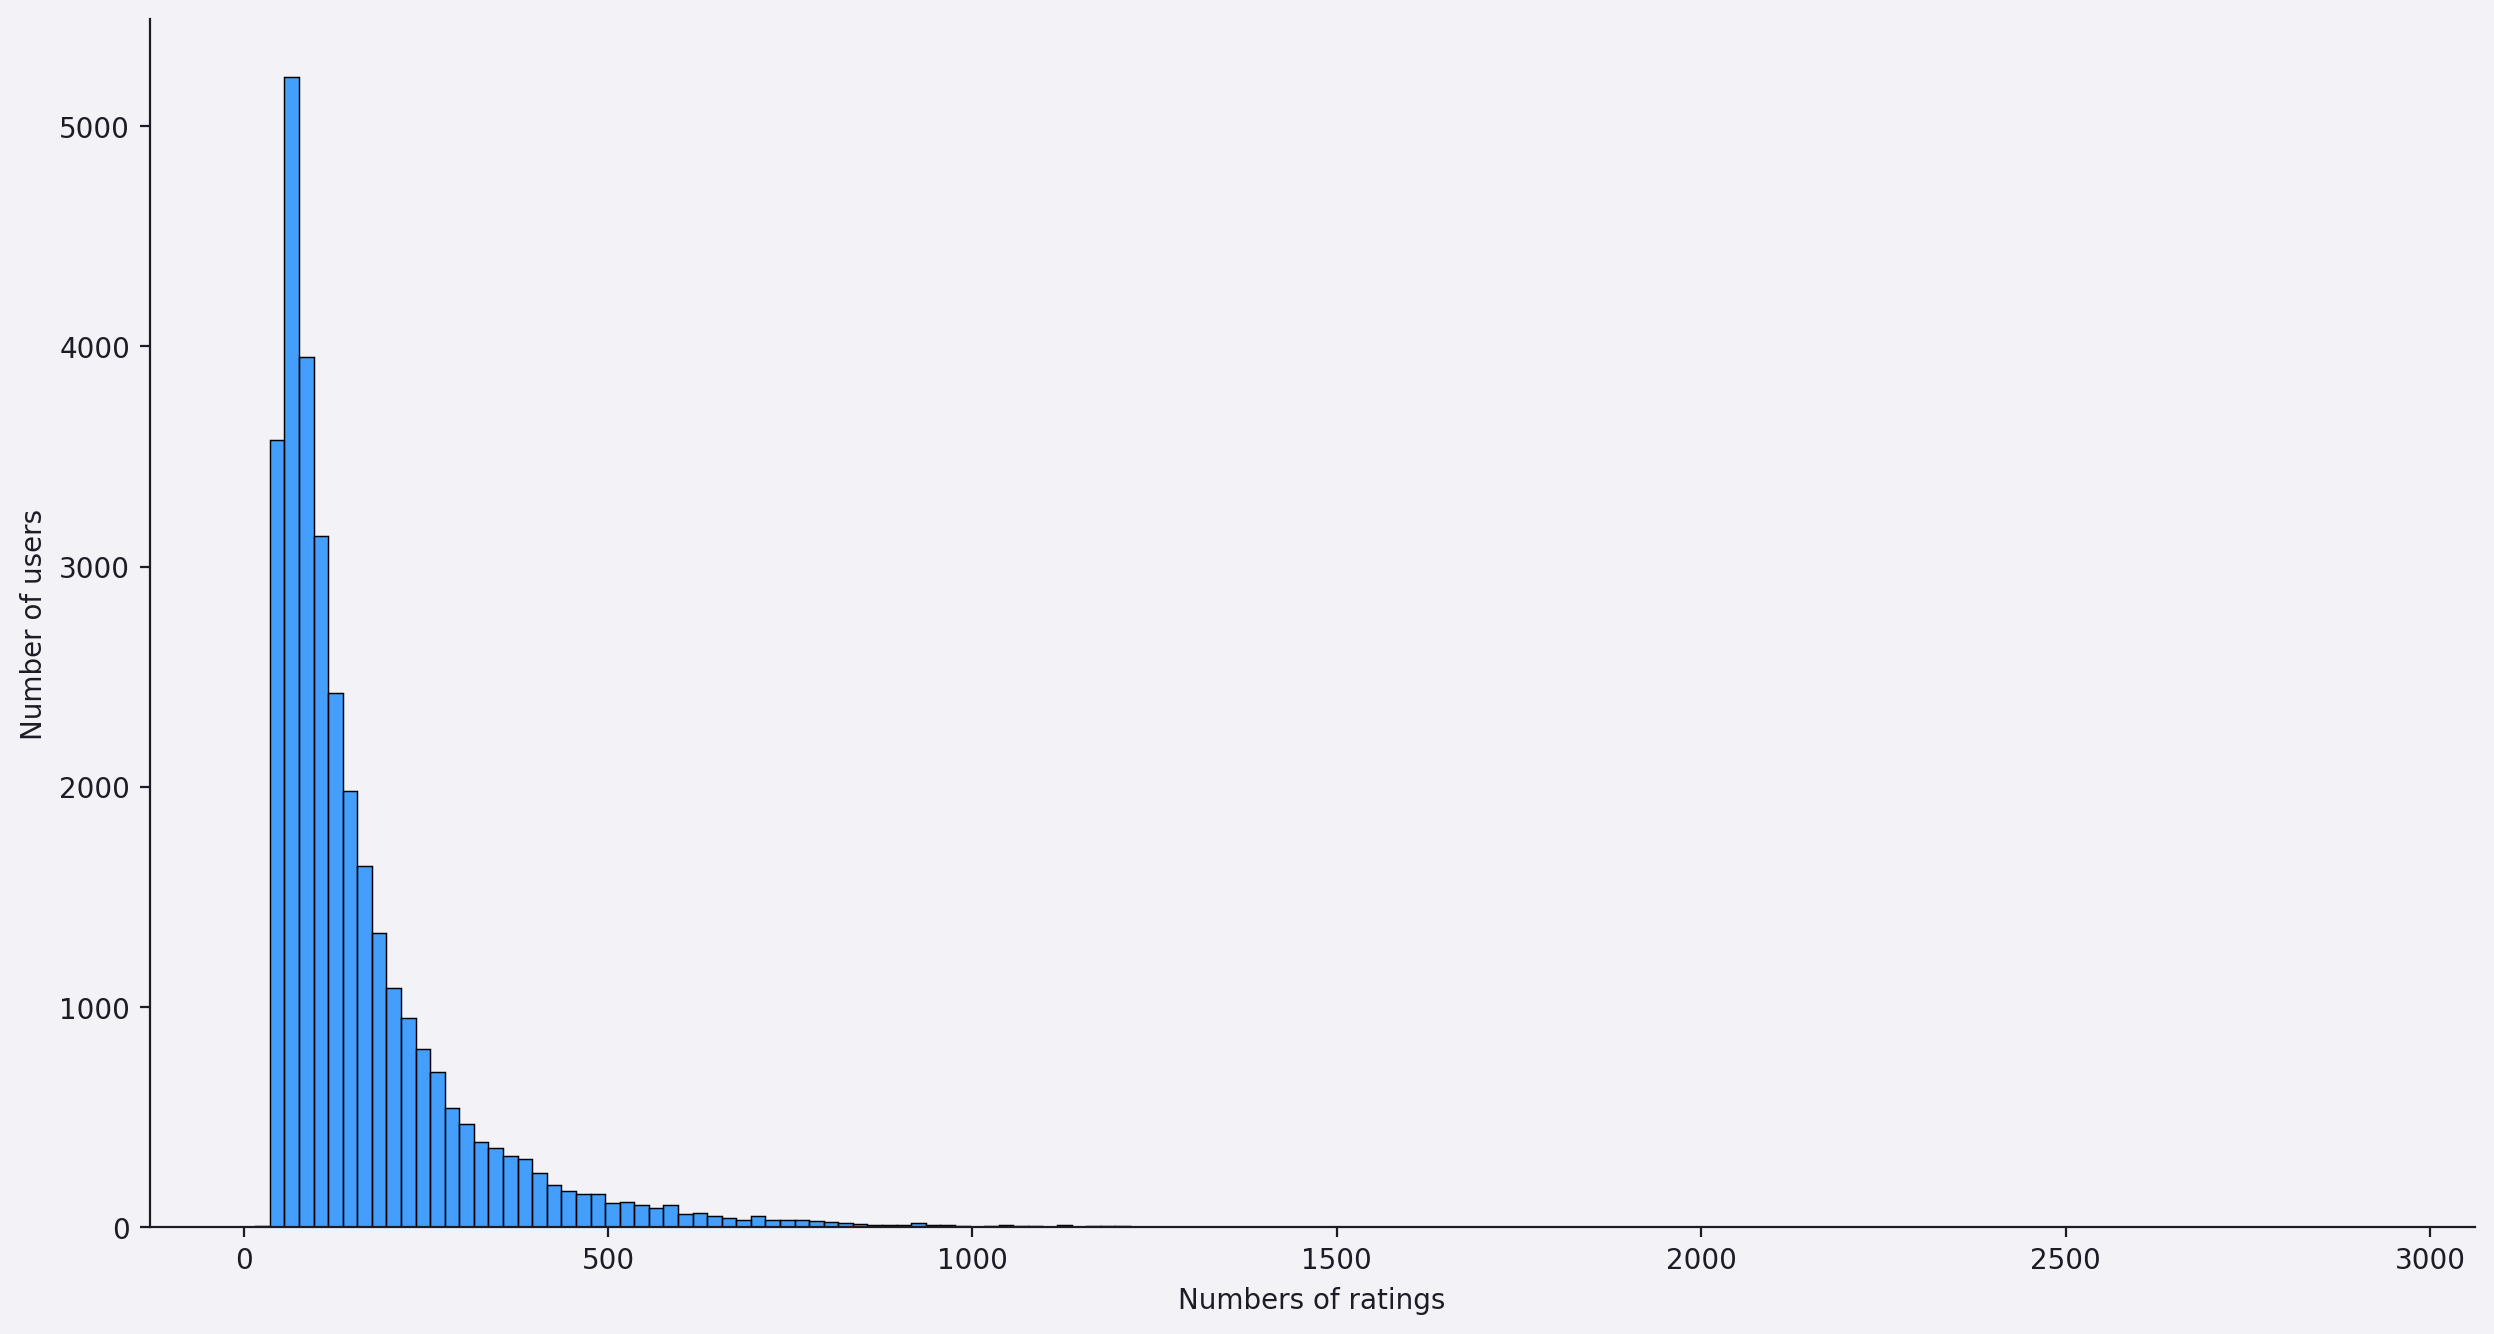

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.histplot(x='count', data=train_df_grouped, binwidth=20, ax=ax)
plt.xlabel('Numbers of ratings')
plt.ylabel('Number of users')

상대적으로 적은 수의 평가를 내린 사람들이 많음을 알 수 있습니다.
한 사람당 500개 이상의 평가를 내린 경우는 많이 드물다는 사실도 알 수 있네요.

시간에 따른 사용자의 영화 interaction 데이터도 분석해봅시다.

In [16]:
train_df_merged = train_df.copy()
train_df_merged

,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563
...,...,...,...
5154466,138493,44022,1260209449
5154467,138493,4958,1260209482
5154468,138493,68319,1260209720
5154469,138493,40819,1260209726


따로 데이터프레임을 만들어서 시간 단위 별로 데이터를 분석합니다.

In [17]:
train_df_merged['time_date'] = pd.to_datetime(train_df_merged['time'], unit='s')
train_df_merged['time_year'] = train_df_merged['time_date'].dt.year
train_df_merged['time_month'] = train_df_merged['time_date'].dt.month
train_df_merged['time_quarter'] = train_df_merged['time_date'].dt.quarter
train_df_merged['time_day'] = train_df_merged['time_date'].dt.day
train_df_merged['time_hour'] = train_df_merged['time_date'].dt.hour
train_df_merged['time_weekday'] = train_df_merged['time_date'].dt.weekday
train_df_merged

,user,item,time,time_date,time_year,time_month,time_quarter,time_day,time_hour,time_weekday
0,11,4643,1230782529,2009-01-01 04:02:09,2009,1,1,1,4,3
1,11,170,1230782534,2009-01-01 04:02:14,2009,1,1,1,4,3
2,11,531,1230782539,2009-01-01 04:02:19,2009,1,1,1,4,3
3,11,616,1230782542,2009-01-01 04:02:22,2009,1,1,1,4,3
4,11,2140,1230782563,2009-01-01 04:02:43,2009,1,1,1,4,3
...,...,...,...,...,...,...,...,...,...,...
5154466,138493,44022,1260209449,2009-12-07 18:10:49,2009,12,4,7,18,0
5154467,138493,4958,1260209482,2009-12-07 18:11:22,2009,12,4,7,18,0
5154468,138493,68319,1260209720,2009-12-07 18:15:20,2009,12,4,7,18,0
5154469,138493,40819,1260209726,2009-12-07 18:15:26,2009,12,4,7,18,0


In [18]:
def make_annotate(ax, size=10000):
    for patch in ax.patches:
        ax.annotate(f'{patch.get_height()}', xy=(patch.get_x() + patch.get_width() / 2, patch.get_height() + size), ha='center')
        if patch.get_height() > size * 2:
            ax.annotate(f'{patch.get_height() / len(train_df_merged) * 100:.2f}%', xy=(patch.get_x() + patch.get_width() / 2, patch.get_height() - size), color='white', va='top', ha='center')

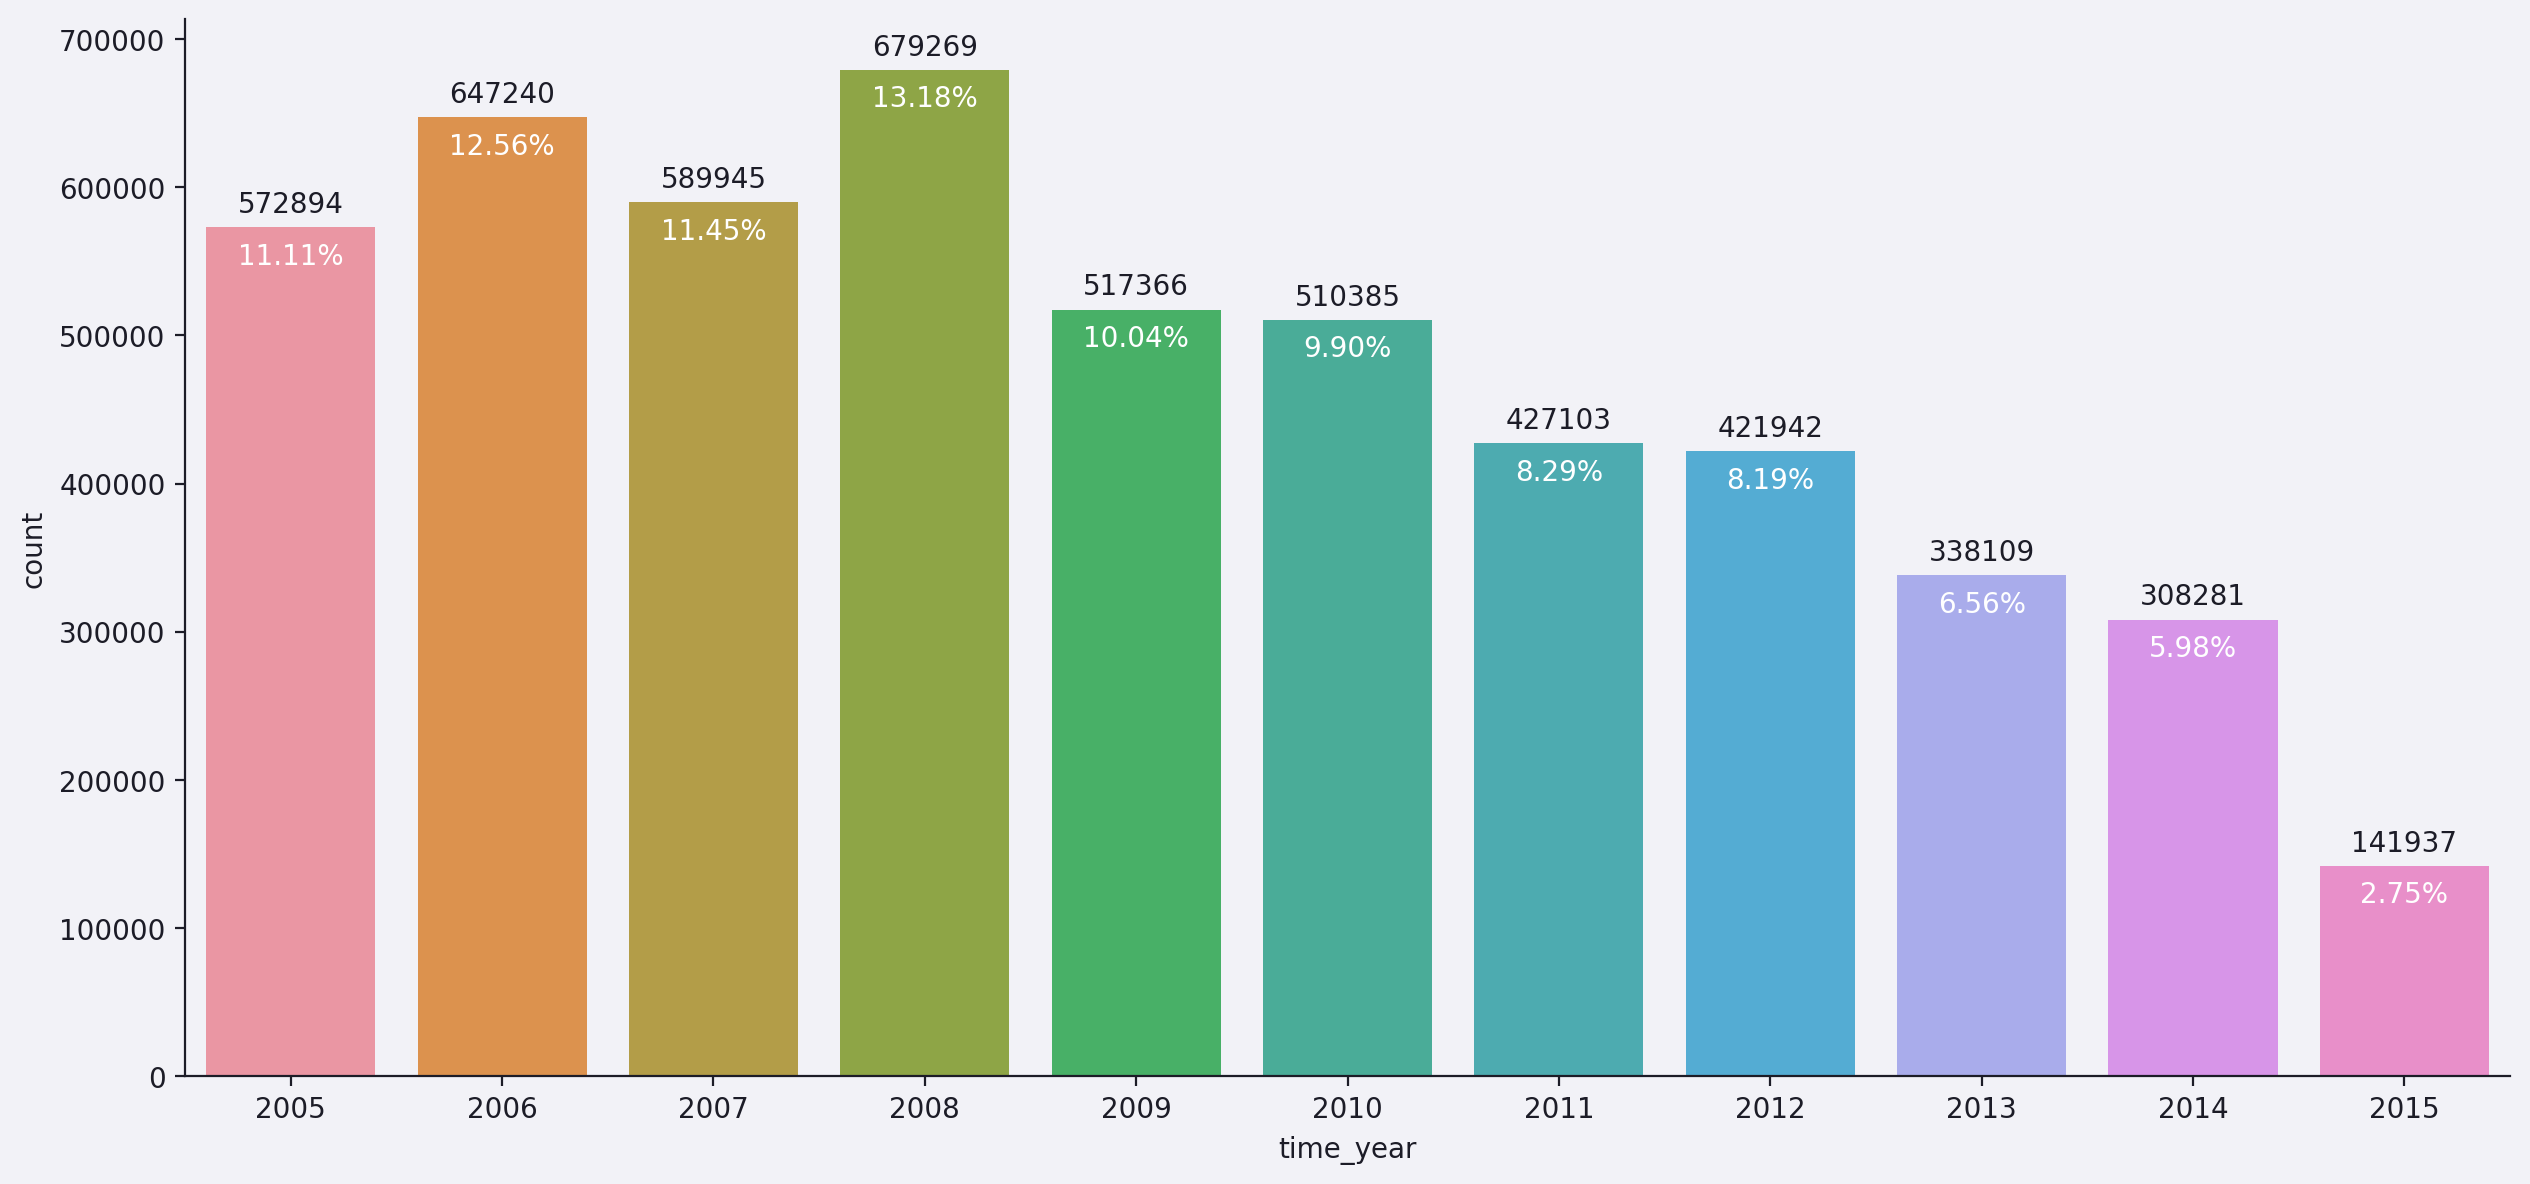

In [19]:
_, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.countplot(x=train_df_merged['time_year'], ax = ax)

make_annotate(ax, 10000)
plt.show()

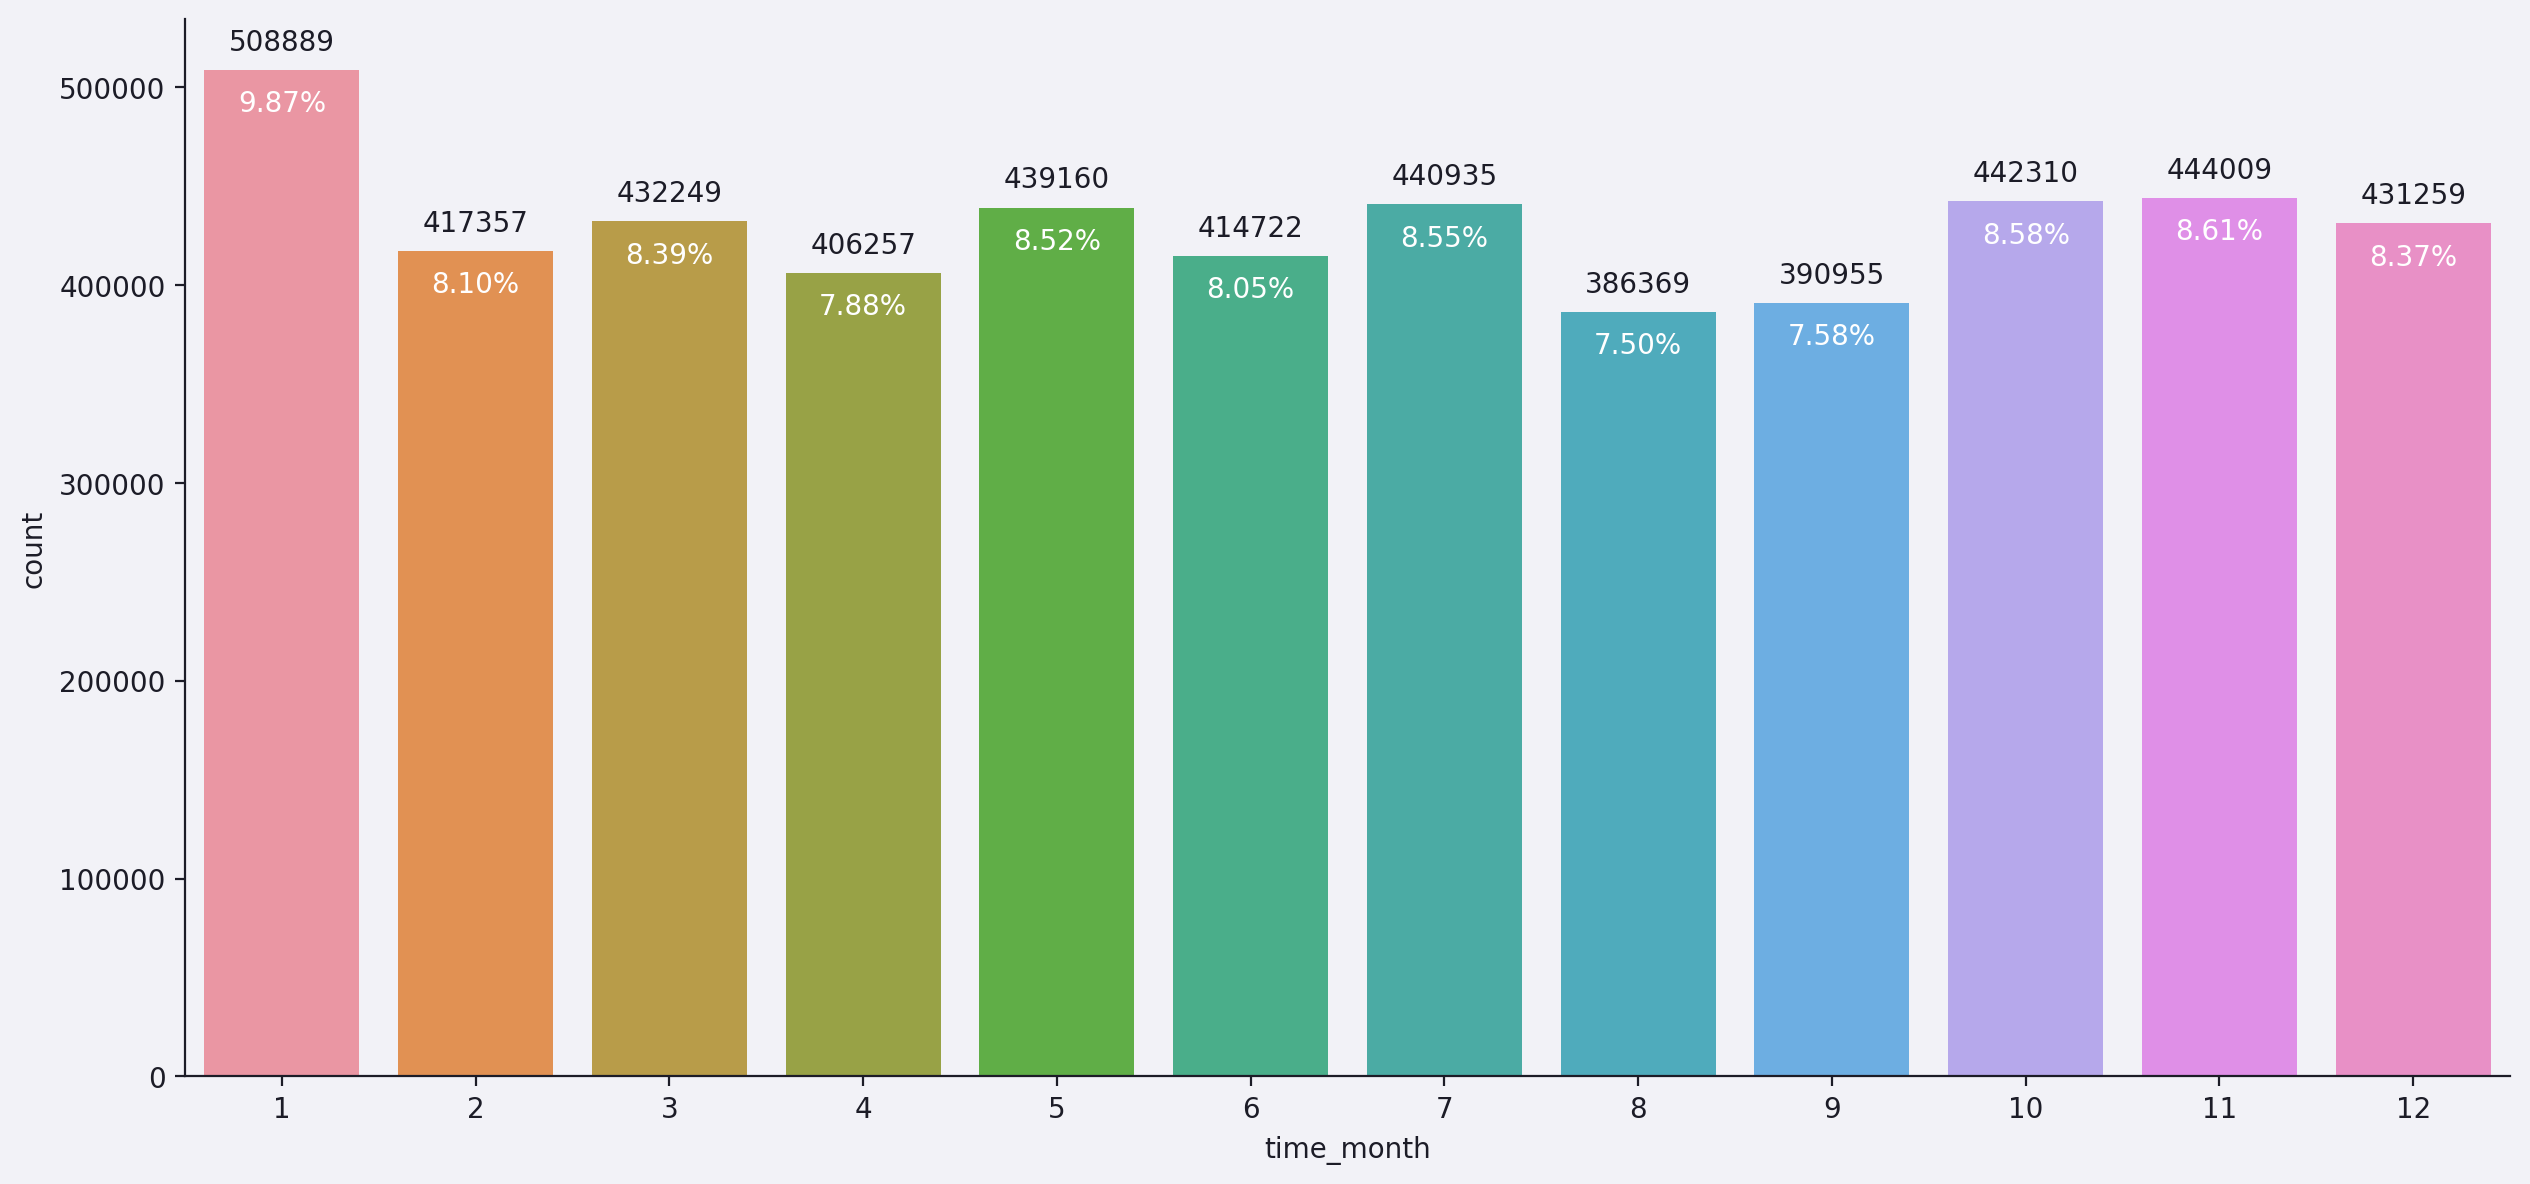

In [20]:
_, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.countplot(x=train_df_merged['time_month'], ax = ax)

make_annotate(ax,10000)
plt.show()

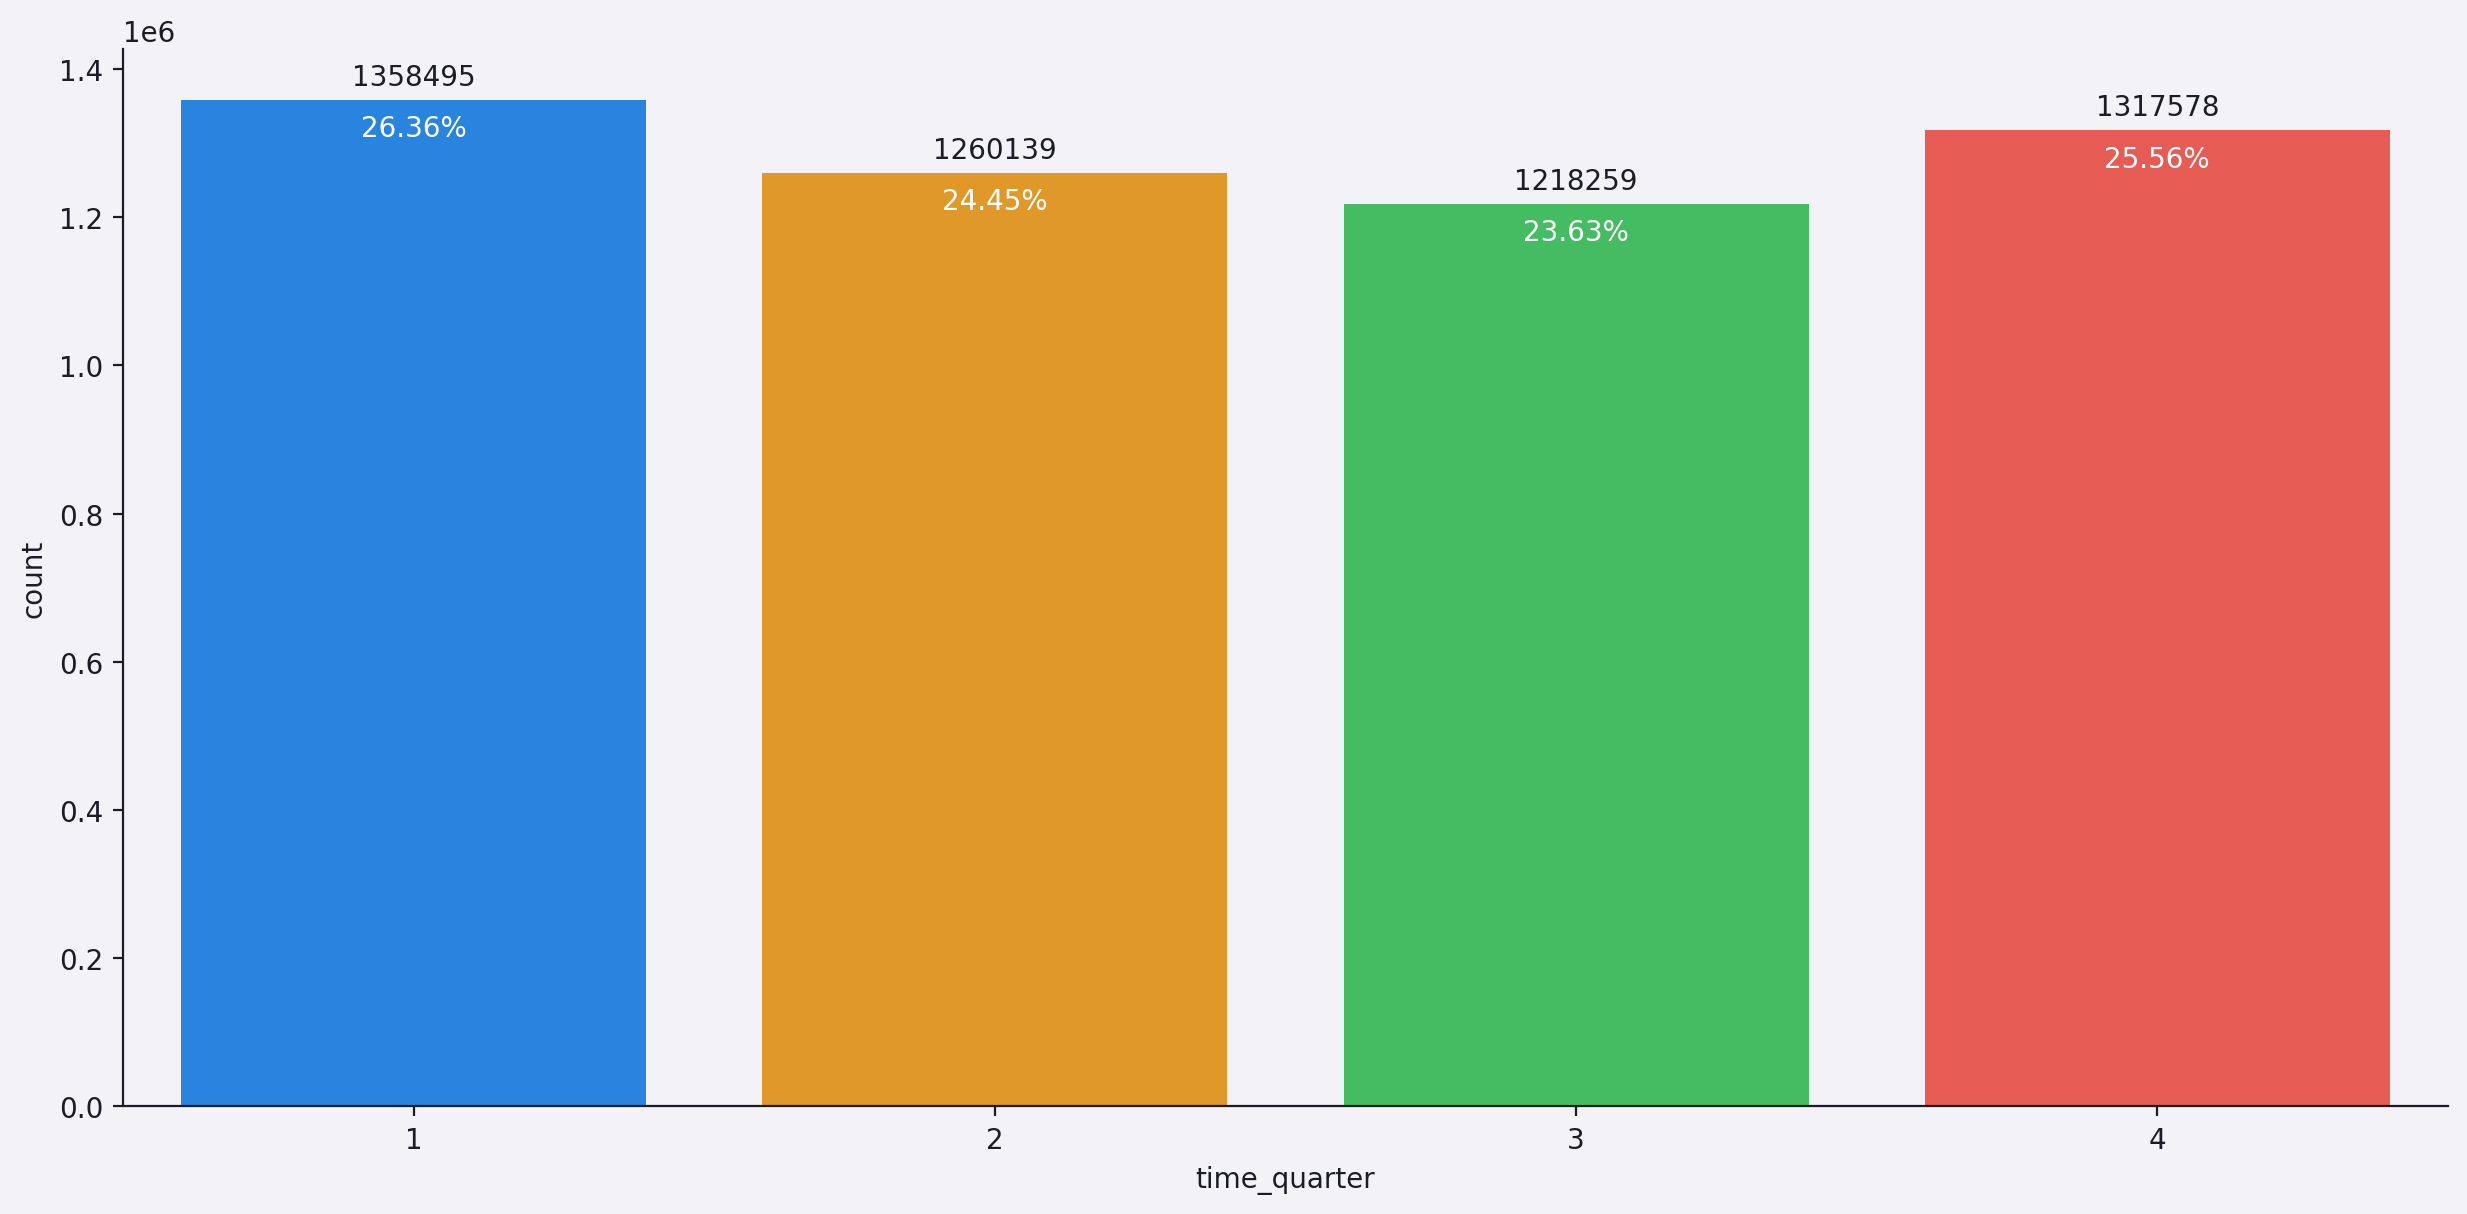

In [21]:
_, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.countplot(x=train_df_merged['time_quarter'], ax = ax, palette=dark_palette)

make_annotate(ax, 20000)
plt.show()

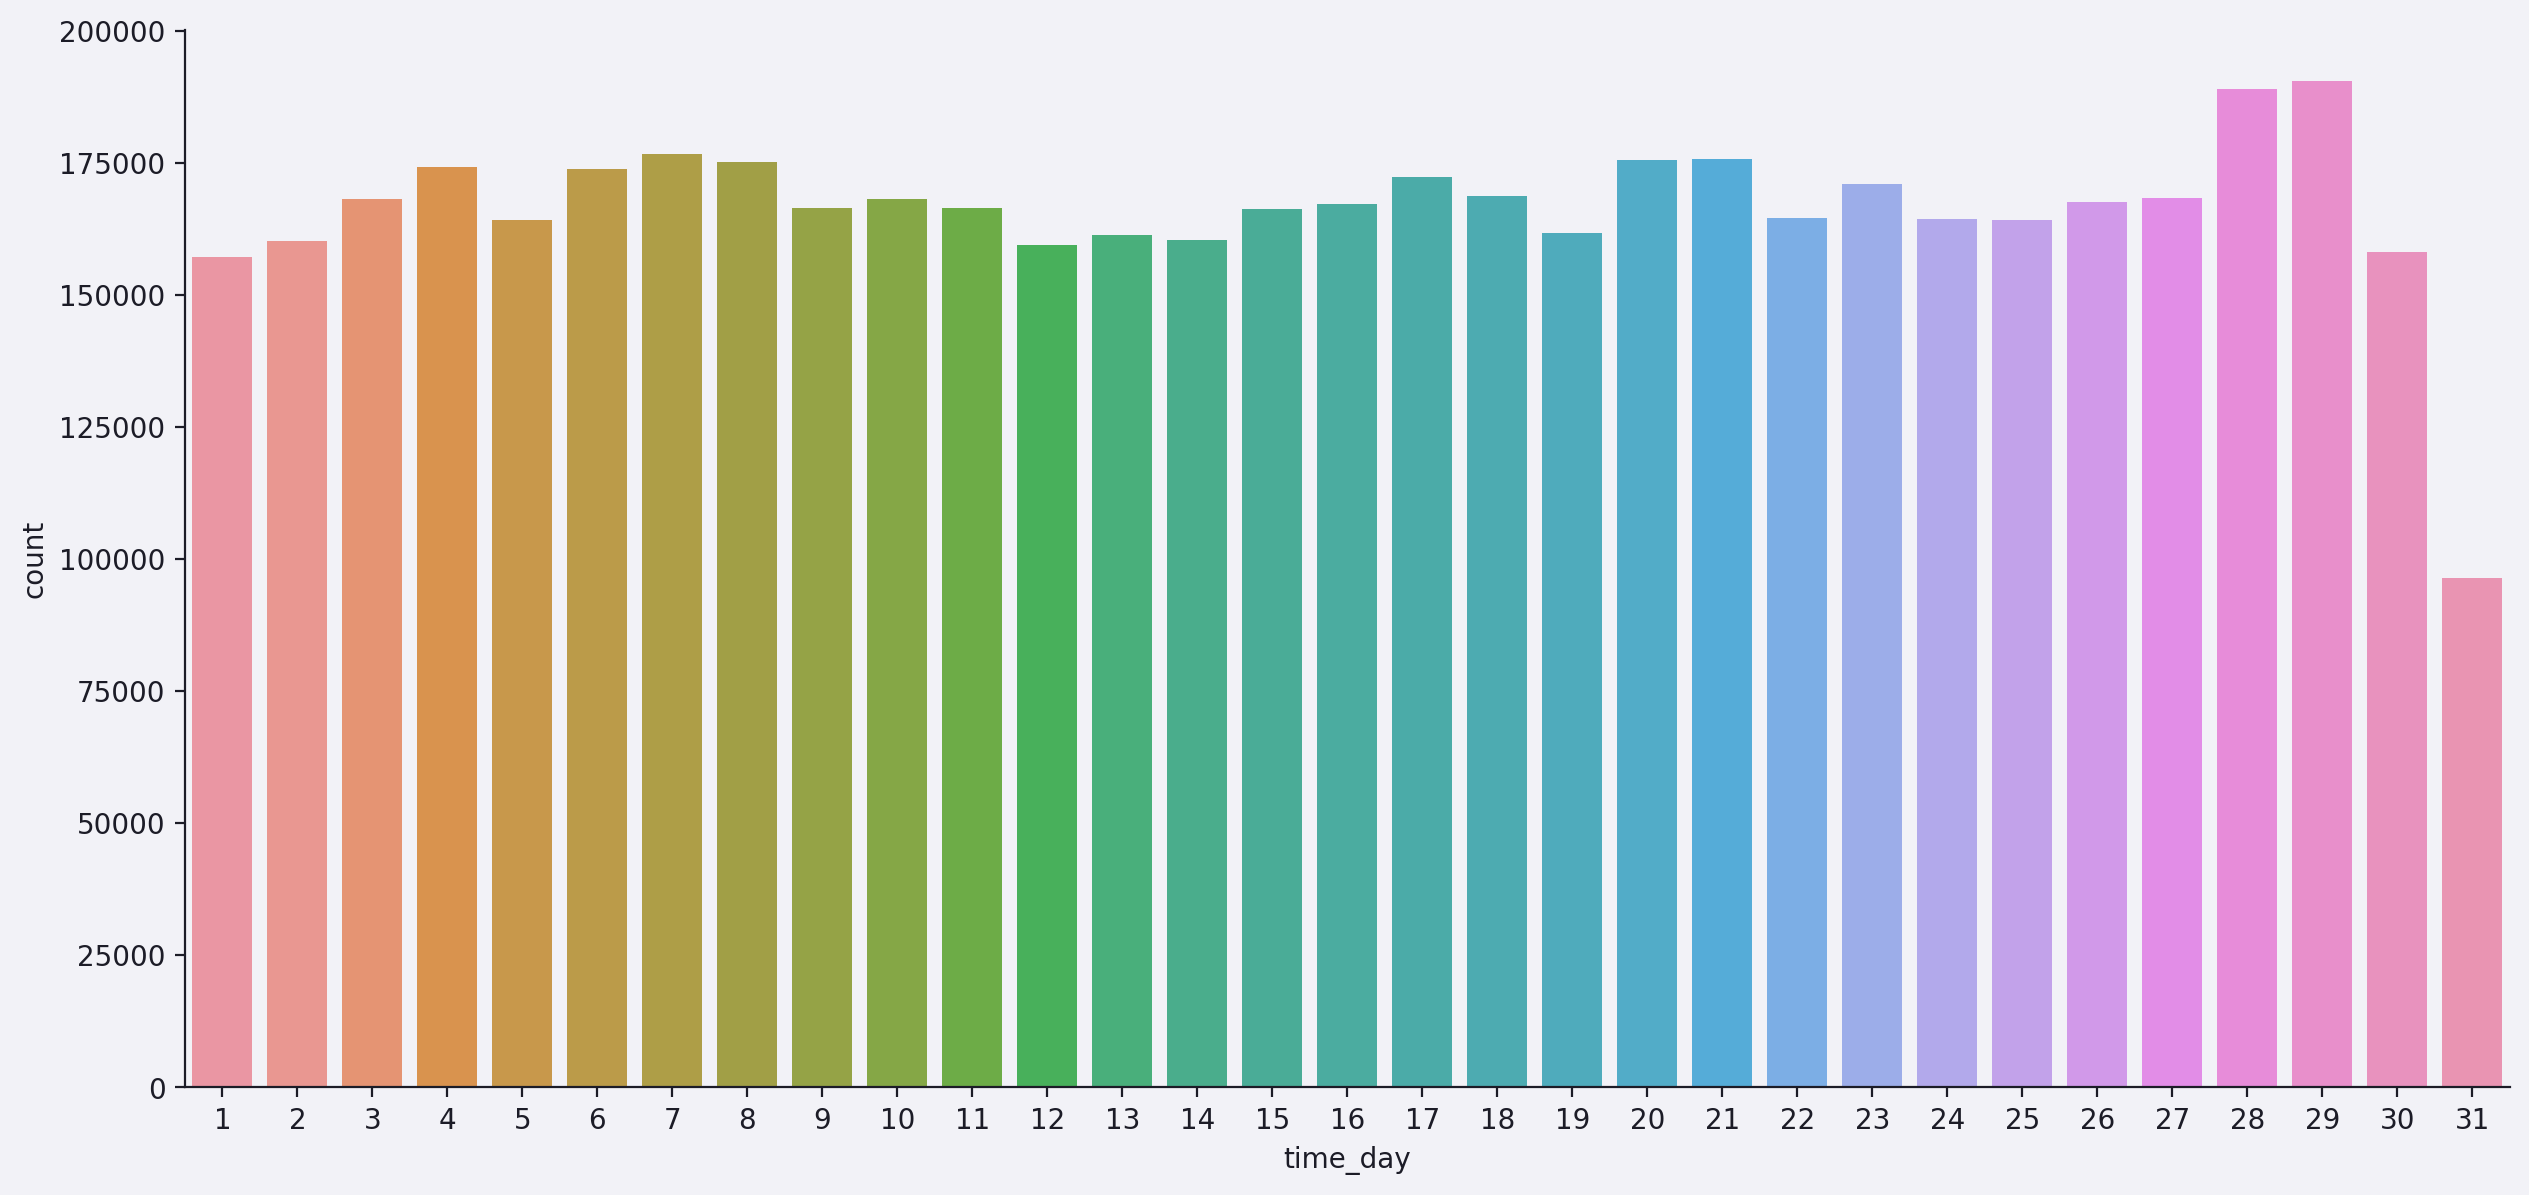

In [22]:
_, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.countplot(x=train_df_merged['time_day'], ax = ax)

plt.show()

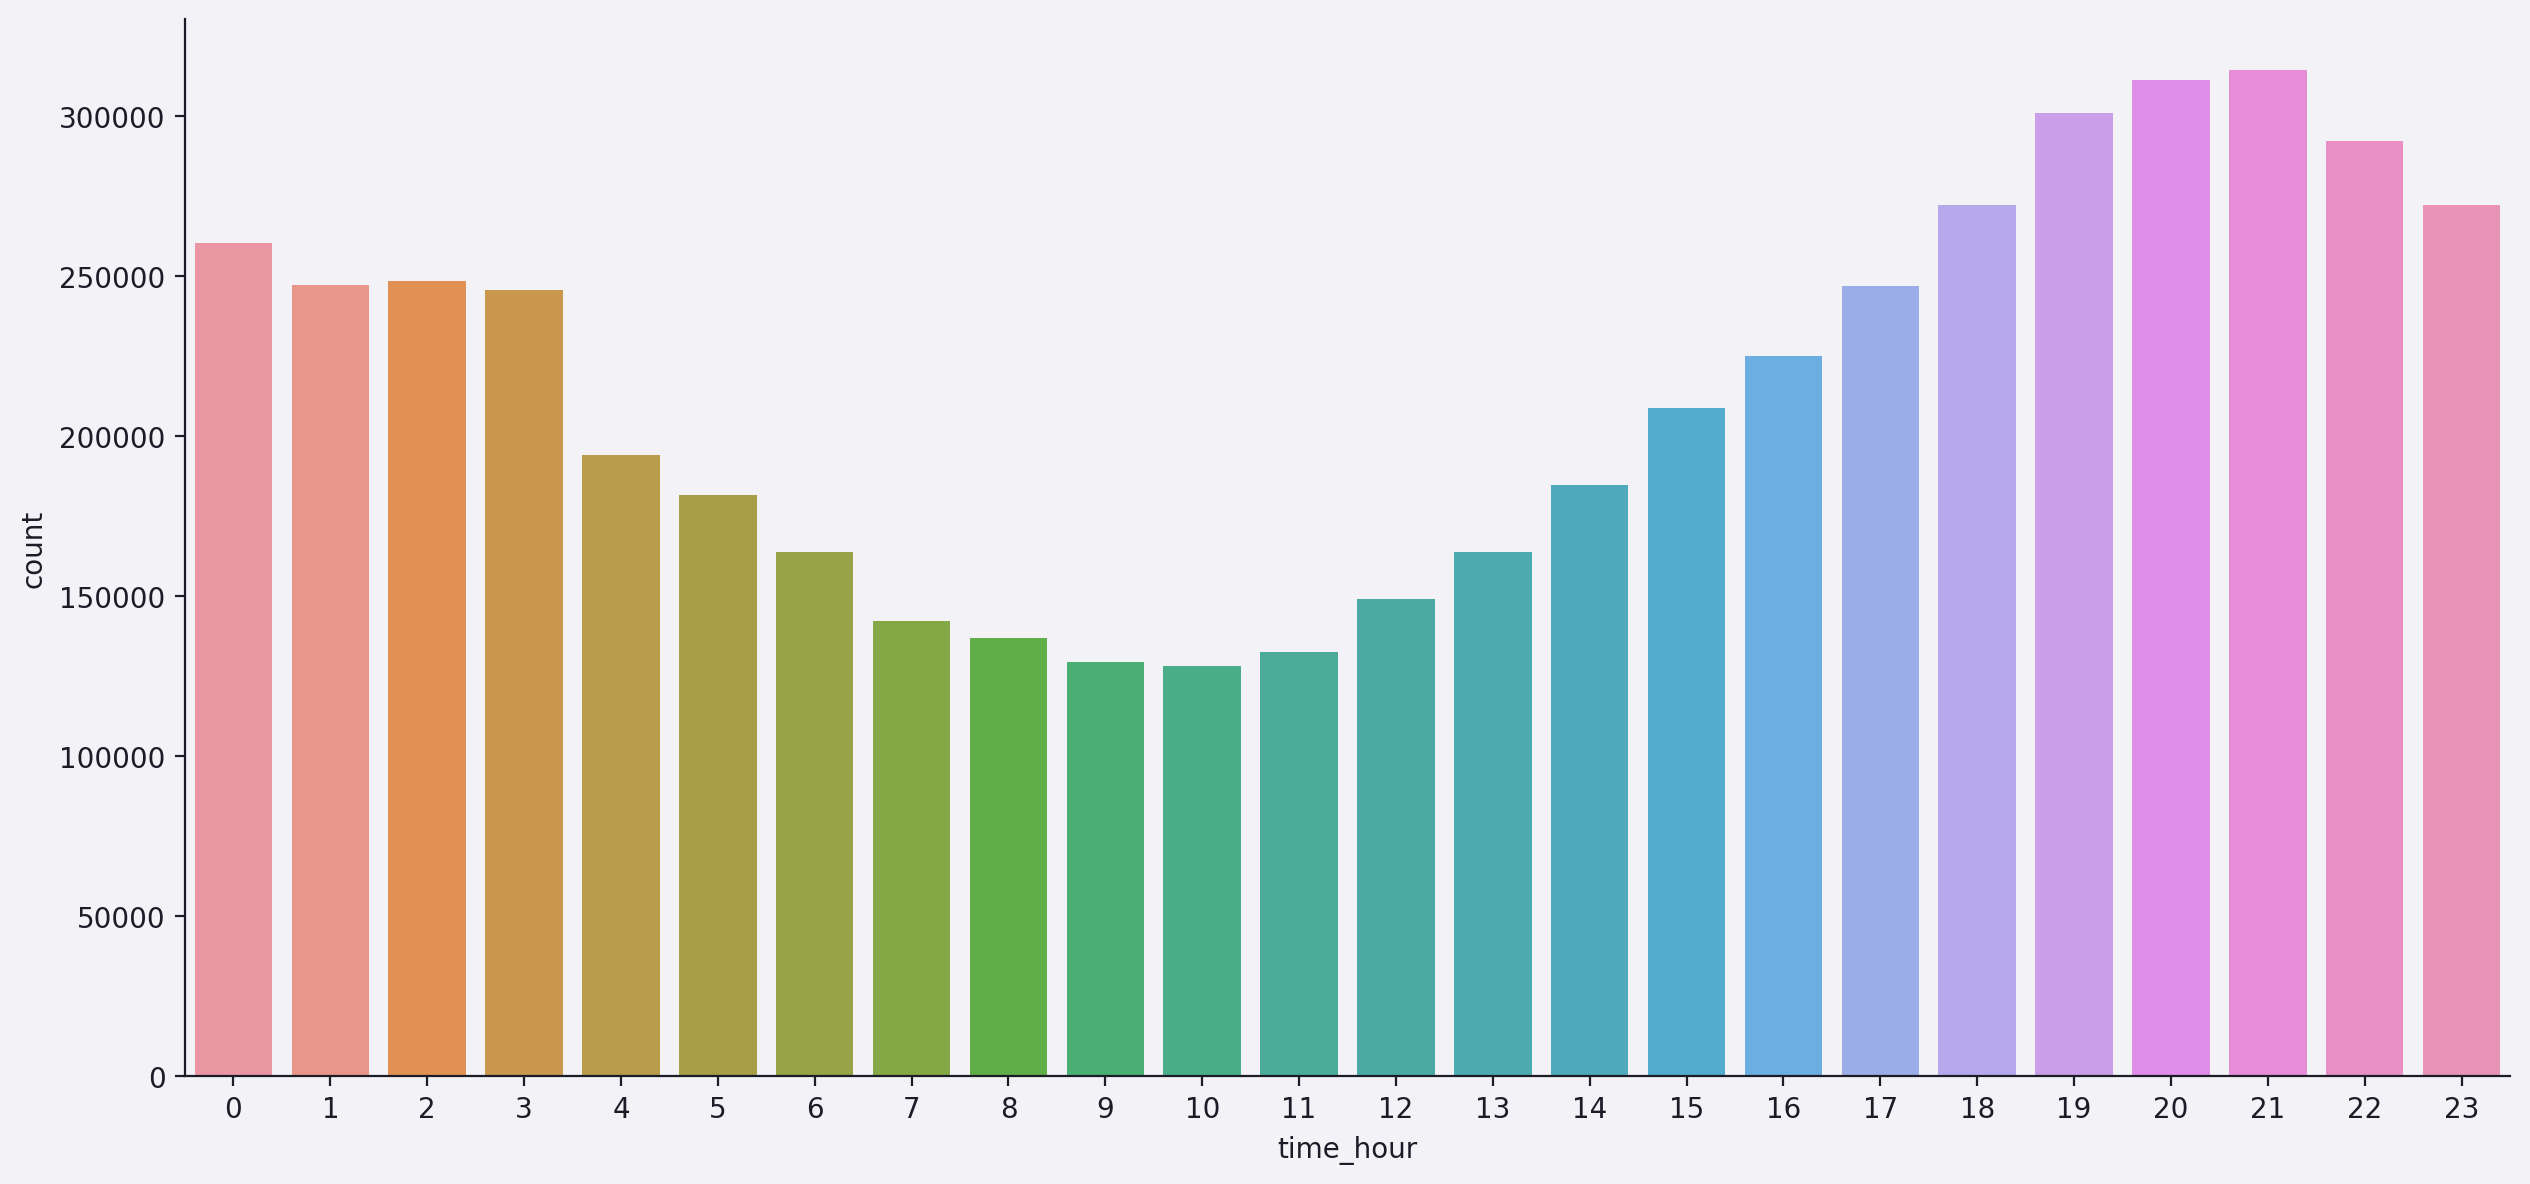

In [23]:
_, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.countplot(x=train_df_merged['time_hour'], ax = ax)

plt.show()

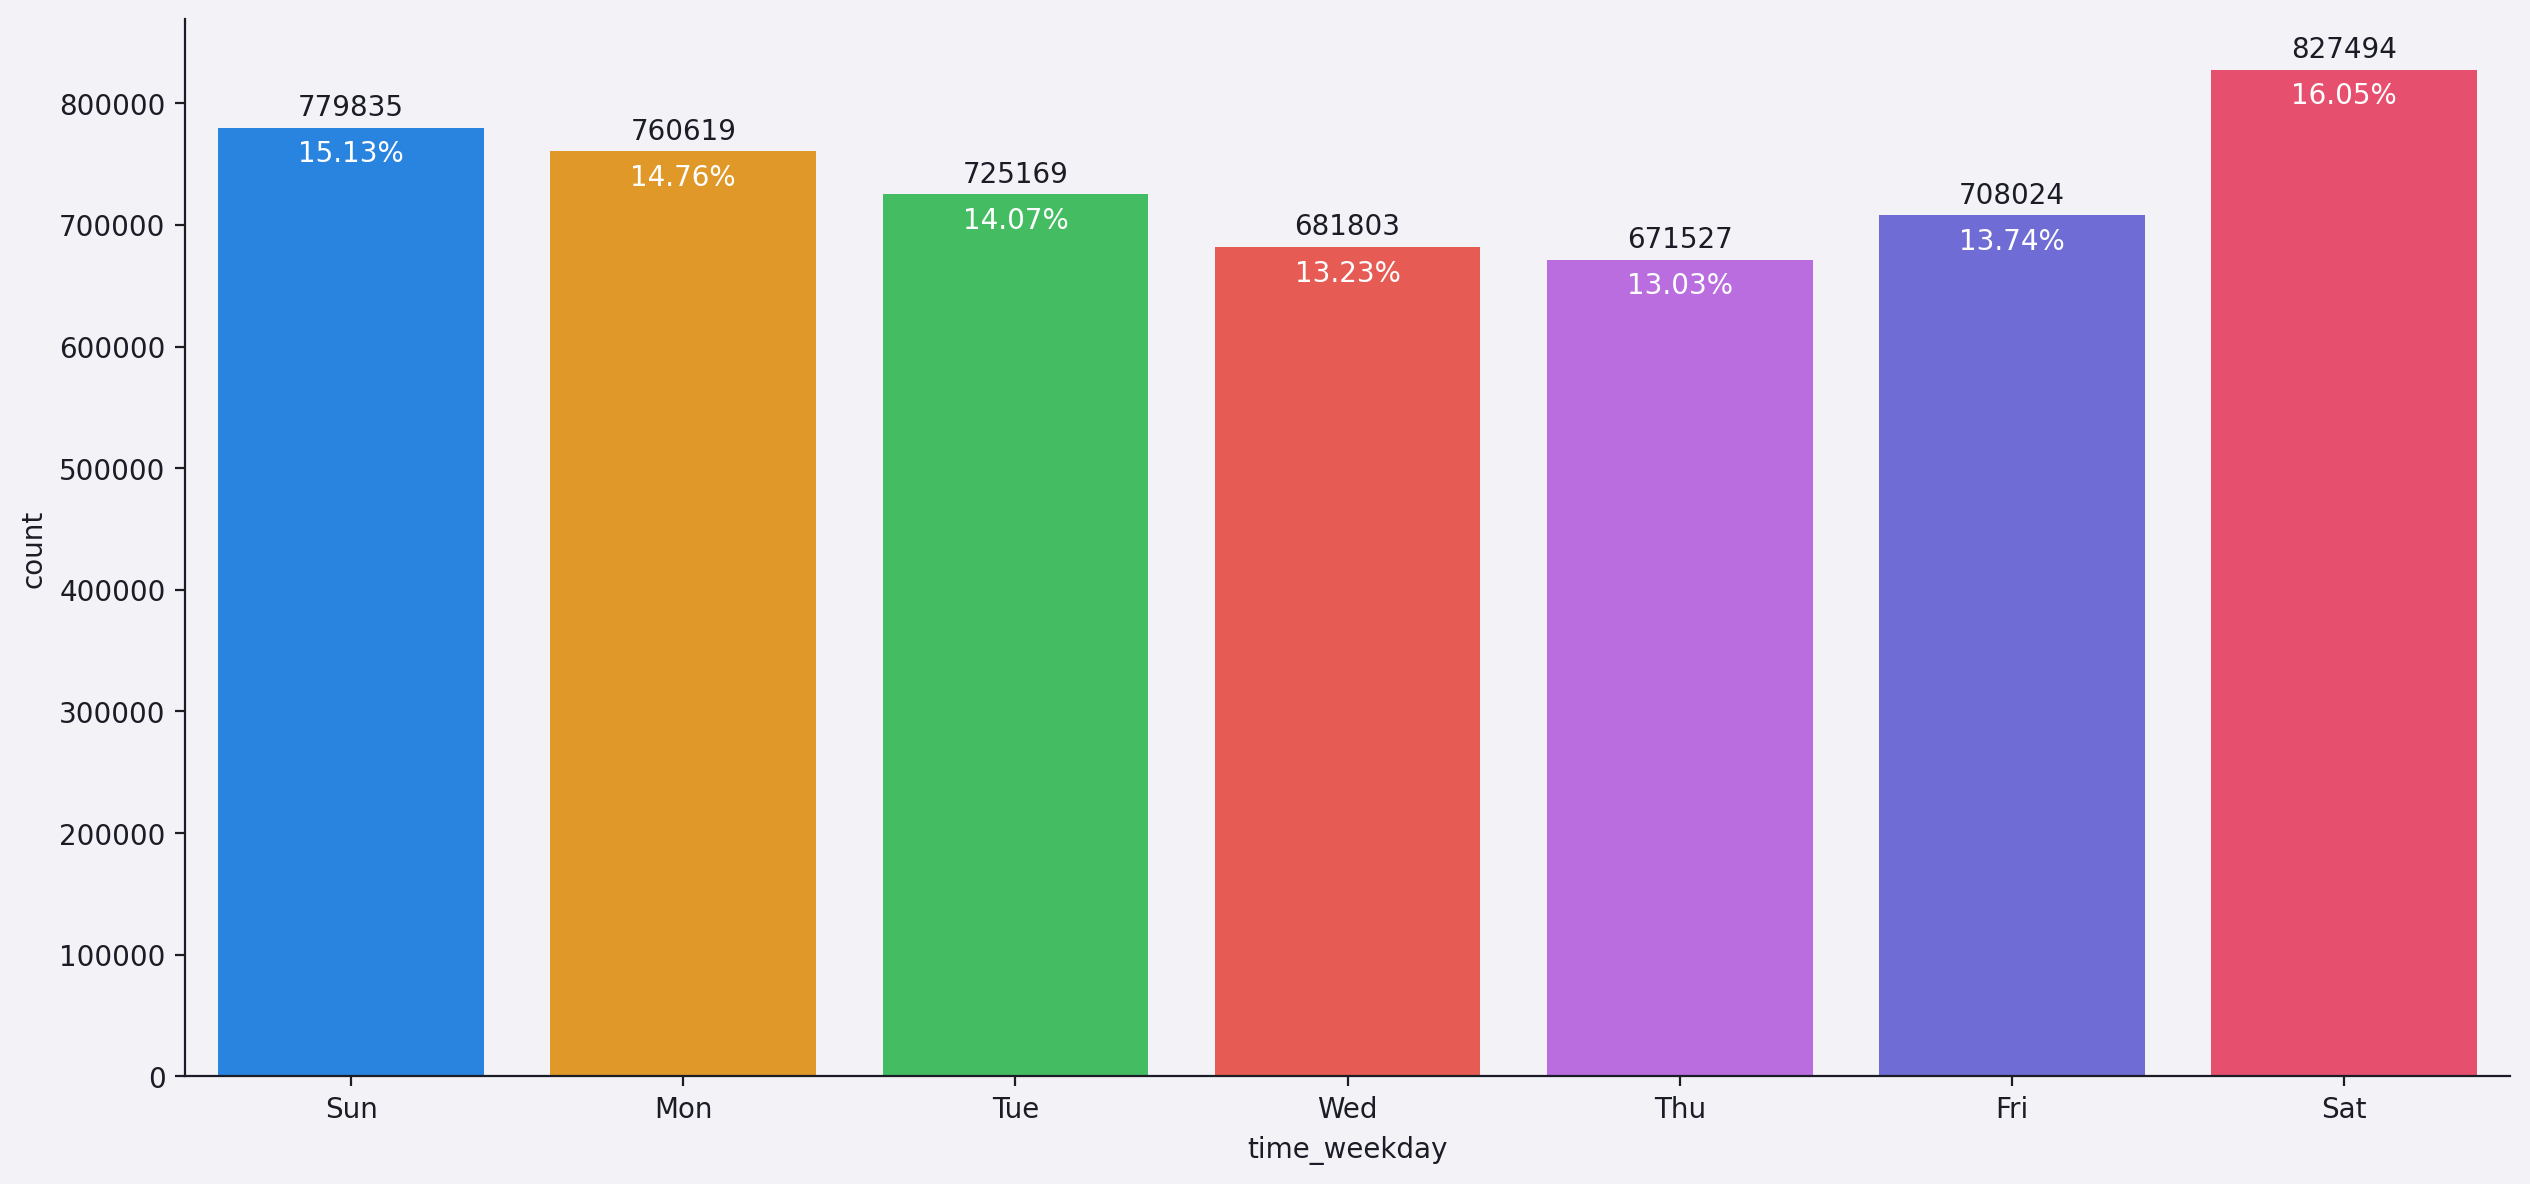

In [24]:
_, ax = plt.subplots(1, 1, figsize=(15, 7))
ax = sns.countplot(x=train_df_merged['time_weekday'], ax = ax, palette=dark_palette)
ax.set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
make_annotate(ax, 10000)
plt.show()

In [25]:
print("Data sparsity ratio: ", 1 - len(train_df) / (num_train_users * num_train_items))

Data sparsity ratio:  0.9758536052697853


데이터의 sparsity ratio는 약 97.6%로 일반적인 추천 시스템 데이터셋에 비해 굉장히 dense한 (행렬 상 이력의 많은 부분이 채워져 있는) 데이터임을 알 수 있습니다.

## Side Information 알아보기

일반적으로 추천시스템에서는 side information을 더욱 잘 활용할수록 더 좋은 추천 결과를 얻을 수 있게 됩니다.

In [26]:
year_data = pd.read_csv(os.path.join(TRAIN_DATA_PATH, TRAIN_YEARS), sep='\t')
writer_data = pd.read_csv(os.path.join(TRAIN_DATA_PATH, TRAIN_WRITERS), sep='\t')
title_data = pd.read_csv(os.path.join(TRAIN_DATA_PATH, TRAIN_TITLES), sep='\t')
genre_data = pd.read_csv(os.path.join(TRAIN_DATA_PATH, TRAIN_GENRES), sep='\t')
director_data = pd.read_csv(os.path.join(TRAIN_DATA_PATH, TRAIN_DIRECTORS), sep='\t')

그러면 먼저 *years.tsv* 데이터를 알아보겠습니다.
각 column은 다음과 같은 정보를 담고 있습니다.
- *item* : 영화 id
- *year* : 해당 영화가 개봉한 연도

In [27]:
year_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6799 entries, 0 to 6798
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   item    6799 non-null   int64
 1   year    6799 non-null   int64
dtypes: int64(2)
memory usage: 106.4 KB


개봉년도는 인덱스가 0부터 6798까지 총 6799개 있음을 알 수 있습니다.
개봉년도의 데이터 형식도 `int`입니다.

In [28]:
year_data.head(10)

,item,year
0,1348,1922
1,44587,1922
2,4768,1922
3,8235,1923
4,8609,1923
5,25750,1924
6,25753,1924
7,4405,1924
8,7074,1924
9,7302,1924


In [29]:
print("Year data shape: ", year_data.shape)
print("Number of unique items in year_data: ", year_data['item'].nunique())
print("Number of unique years: ", year_data['year'].nunique())

Year data shape:  (6799, 2)
Number of unique items in year_data:  6799
Number of unique years:  93


개봉년도 데이터에서 unique item 수는 6,799개인데, 앞서 살펴 본 interaction 데이터에서는 unique item 수가 6,807개입니다.
연도 정보가 없는 item이 있다는 건데, 개봉년도가 없는 데이터를 찾아봅시다.

In [30]:
unique_item_set = set(train_df['item'].unique())
non_year_movies = unique_item_set.difference(set(year_data['item'].unique()))
print(non_year_movies)

{32898, 119145, 6987, 6988, 7243, 3310, 7065, 8511}


위의 값을 지닌 영화 item은 개봉년도 정보가 없습니다.

In [31]:
join_year_data = pd.merge(train_df, year_data, how='left', on='item')
join_year_data[join_year_data['year'].isnull()].item.value_counts()

6987      763
3310      480
32898     183
7065      109
7243       78
119145     78
8511       71
6988       70
Name: item, dtype: int64

개봉년도가 없는 영화 중 사용자와 영화의 interaction 데이터에서 가장 많은 수를 지닌 영화 item 값은 6987입니다.

In [32]:
print ("Statistics of year data: ")
year_data['year'].describe()

Statistics of year data: 


count    6799.000000
mean     1992.174732
std        19.052568
min      1922.000000
25%      1985.000000
50%      1999.000000
75%      2006.000000
max      2014.000000
Name: year, dtype: float64

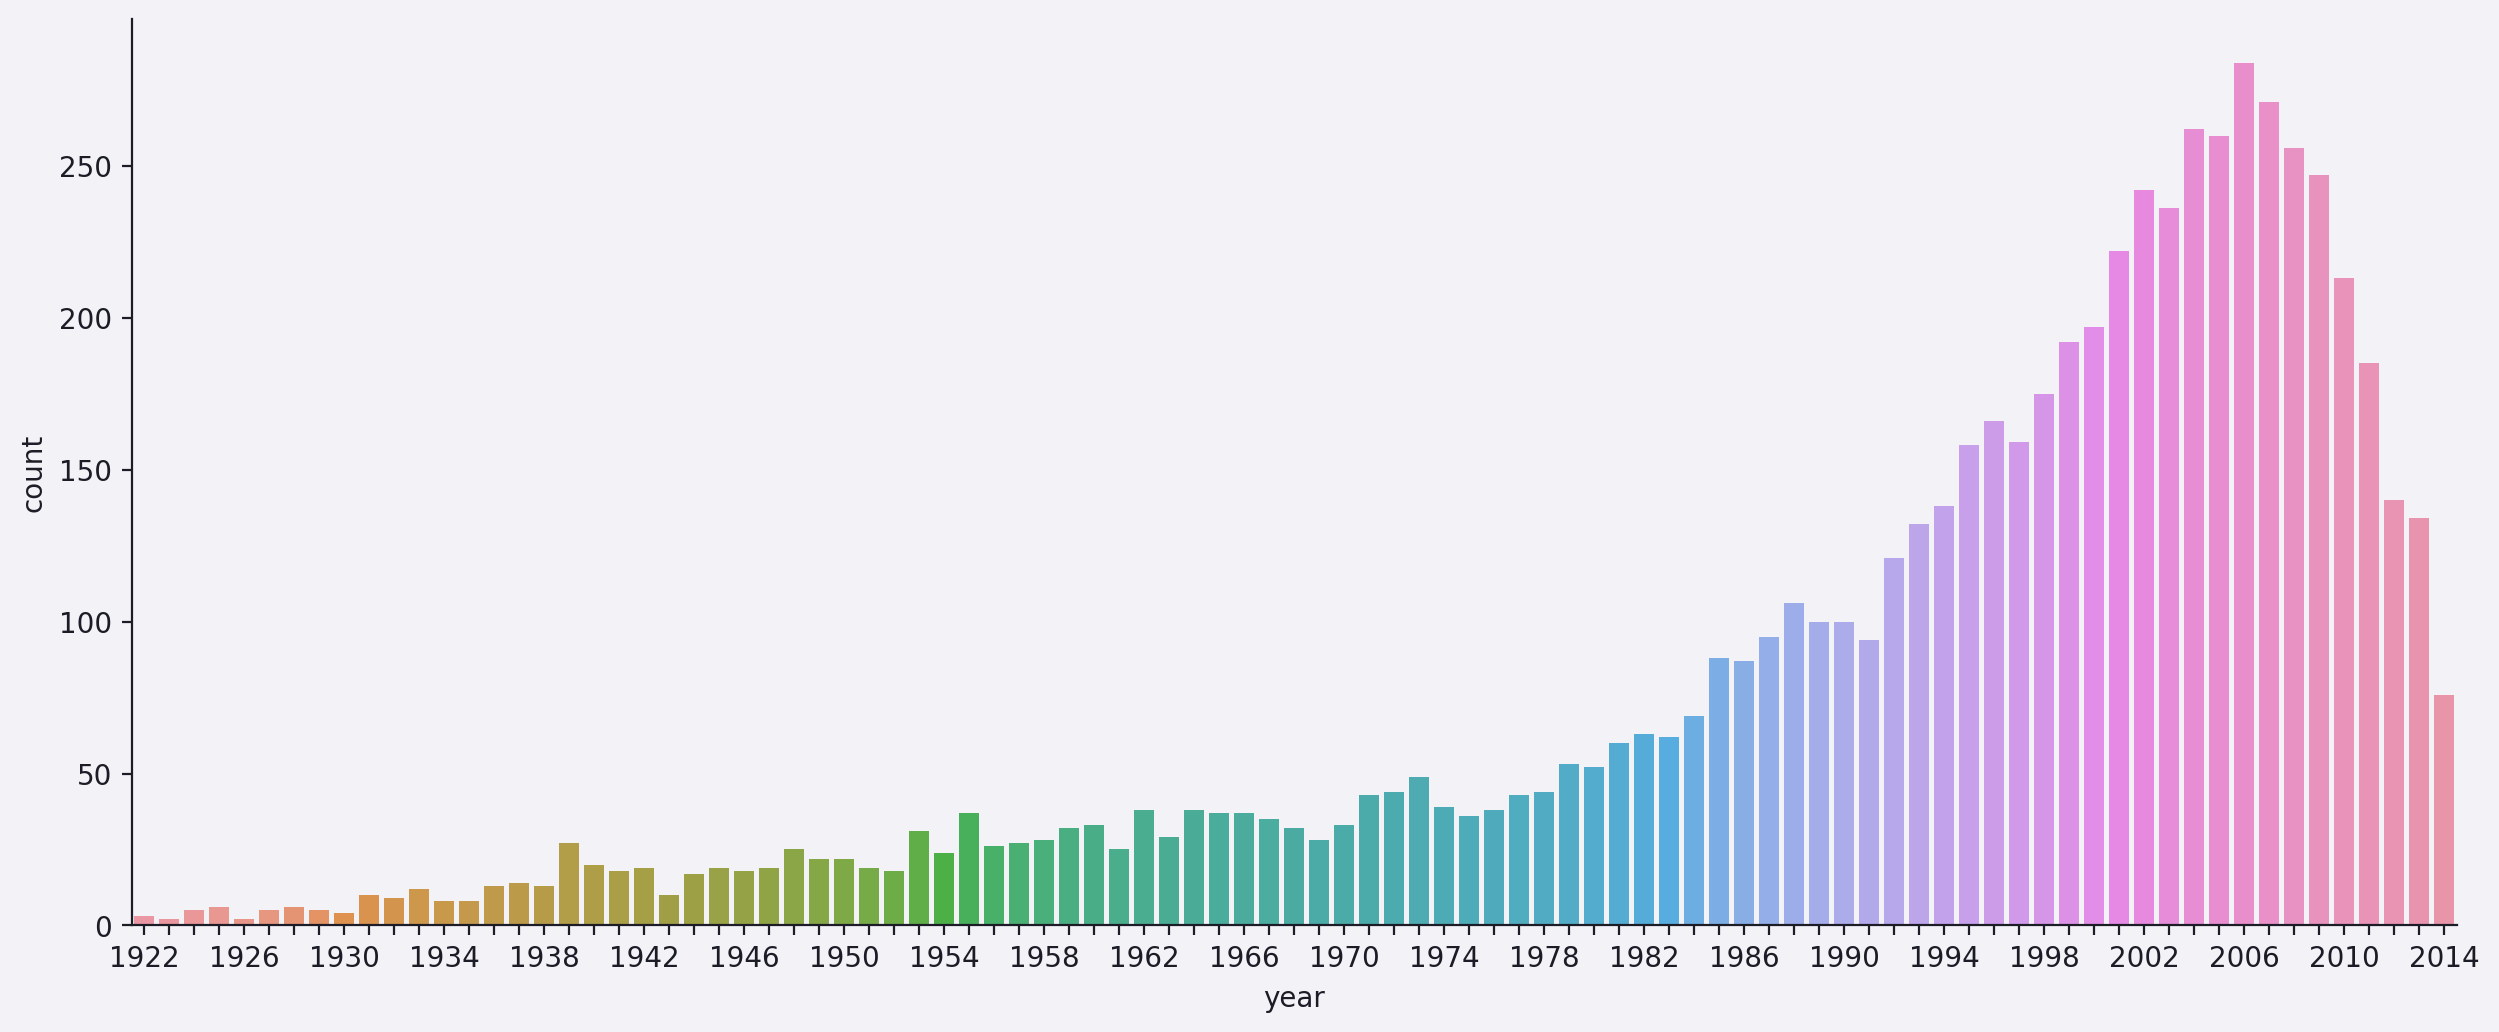

In [33]:
_, ax = plt.subplots(1, 1, figsize=(15, 6))
ax = sns.countplot(x=year_data['year'], ax=ax)

for index, label in enumerate(ax.get_xticklabels()):
    if index % 4 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.show()

개봉년도의 최솟값은 1922년, 최댓값은 2014년, 평균은 1992년입니다.
2000년 대에 가장 많은 영화가 개봉했음을 알 수 있습니다.

다음은 *writers.tsv* 데이터입니다.
각 column은 다음과 같은 정보를 담고 있습니다.

- *item* : 영화 id
- *writer* : 영화의 각본가 (익명화)


In [34]:
writer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11306 entries, 0 to 11305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    11306 non-null  int64 
 1   writer  11306 non-null  object
dtypes: int64(1), object(1)
memory usage: 176.8+ KB


In [35]:
writer_data.head(10)

,item,writer
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005
3,2068,nm0000005
4,7396,nm0000005
5,4422,nm0000005
6,7939,nm0000005
7,7938,nm0000005
8,7941,nm0000005
9,7937,nm0000005


In [36]:
print("Writer data shape: ", writer_data.shape)
print("Number of unique items in writer_data: ", writer_data['item'].nunique())
print("Number of unique writers: ", writer_data['writer'].nunique())

Writer data shape:  (11306, 2)
Number of unique items in writer_data:  5648
Number of unique writers:  2989


앞에서 살펴 본 영화 수에 비해 작가 정보가 없는 영화도 적지 않게 있음을 유추할 수 있습니다.

In [37]:
non_writer_movies = set(train_df['item'].unique()) - set(writer_data['item'].unique())
print("Number of movies that have no information of writer: ", len(non_writer_movies))

Number of movies that have no information of writer:  1159


작가 정보가 없는 영화 데이터 결측치는 어떻게 처리하는 게 바람직할지 고민이 됩니다.

In [38]:
writer_data_grouped = writer_data.groupby(writer_data['writer'])['item'].count().reset_index(name="writer_count")
writer_data_grouped['writer_count'].describe()

count    2989.000000
mean        3.782536
std         2.993783
min         2.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        47.000000
Name: writer_count, dtype: float64

작가 별로 최소 2개 이상의 영화는 썼고, 평균적으로 3.8개의 영화를 썼음을 알 수 있습니다.
영화 1개만 쓴 작가는 없다는 게 생각보다 신기하네요.

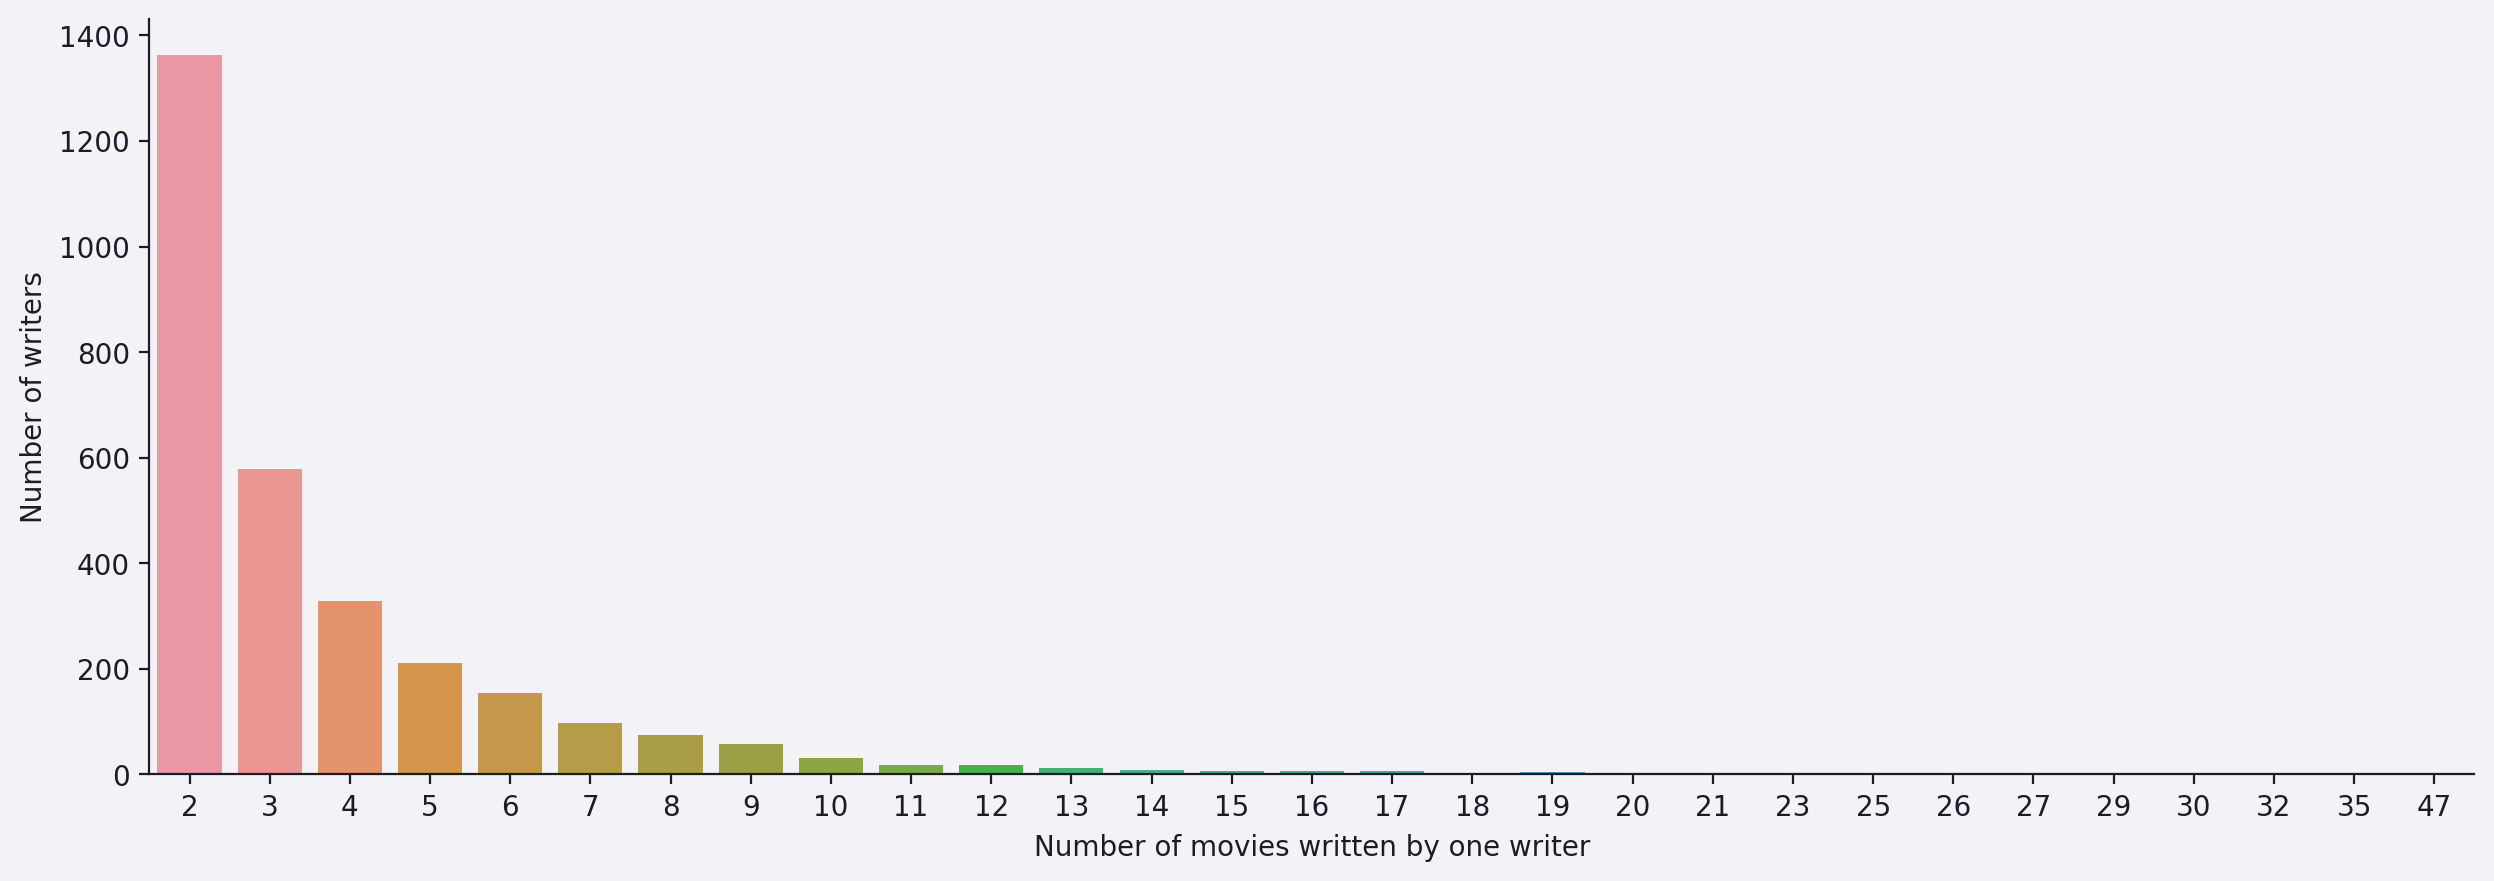

In [39]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.countplot(x=writer_data_grouped['writer_count'], ax = ax)
plt.xlabel('Number of movies written by one writer')
plt.ylabel('Number of writers')
plt.show()

다음은 *titles.tsv* 데이터입니다.
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id
- *titles* : 영화 제목

In [40]:
title_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    6807 non-null   int64 
 1   title   6807 non-null   object
dtypes: int64(1), object(1)
memory usage: 106.5+ KB


제목 데이터의 총 길이는 6,807개이고, 결측치는 없는 것으로 보입니다.

In [41]:
title_data.head(10)

,item,title
0,318,"Shawshank Redemption, The (1994)"
1,2571,"Matrix, The (1999)"
2,2959,Fight Club (1999)
3,296,Pulp Fiction (1994)
4,356,Forrest Gump (1994)
5,4993,"Lord of the Rings: The Fellowship of the Ring, The (2001)"
6,7153,"Lord of the Rings: The Return of the King, The (2003)"
7,5952,"Lord of the Rings: The Two Towers, The (2002)"
8,593,"Silence of the Lambs, The (1991)"
9,2858,American Beauty (1999)


In [42]:
print("Title data shape: ", title_data.shape)
print("Number of unique items in title_data: ", title_data['item'].nunique())
print("Number of unique titles: ", title_data['title'].nunique())

Title data shape:  (6807, 2)
Number of unique items in title_data:  6807
Number of unique titles:  6806


영화는 6,807개로 모든 영화가 어떤 사용자에 의해 한 번씩 평점이 매겨진 건 사실입니다.
그런데 왜 영화의 unique title 개수가 6,806개로 1개 부족할까요?

In [43]:
title_data[title_data['title'].duplicated(keep=False)]

,item,title
349,34048,War of the Worlds (2005)
1926,64997,War of the Worlds (2005)


item 값이 34048인 영화와 64997인 영화의 title이 서로 중복됩니다.
이를 어떻게 처리하는 것이 바람직할까요?
그냥 그대로 두는 것이 맞을까요, 아니면 다른 side-information을 이용해서 둘의 차이를 만들어 주는 게 맞을까요?

In [44]:
train_df_merged = pd.merge(train_df_merged, title_data, how='left', on='item')
train_df_merged

,user,item,time,time_date,time_year,time_month,time_quarter,time_day,time_hour,time_weekday,title
0,11,4643,1230782529,2009-01-01 04:02:09,2009,1,1,1,4,3,Planet of the Apes (2001)
1,11,170,1230782534,2009-01-01 04:02:14,2009,1,1,1,4,3,Hackers (1995)
2,11,531,1230782539,2009-01-01 04:02:19,2009,1,1,1,4,3,"Secret Garden, The (1993)"
3,11,616,1230782542,2009-01-01 04:02:22,2009,1,1,1,4,3,"Aristocats, The (1970)"
4,11,2140,1230782563,2009-01-01 04:02:43,2009,1,1,1,4,3,"Dark Crystal, The (1982)"
...,...,...,...,...,...,...,...,...,...,...,...
5154466,138493,44022,1260209449,2009-12-07 18:10:49,2009,12,4,7,18,0,Ice Age 2: The Meltdown (2006)
5154467,138493,4958,1260209482,2009-12-07 18:11:22,2009,12,4,7,18,0,Behind Enemy Lines (2001)
5154468,138493,68319,1260209720,2009-12-07 18:15:20,2009,12,4,7,18,0,X-Men Origins: Wolverine (2009)
5154469,138493,40819,1260209726,2009-12-07 18:15:26,2009,12,4,7,18,0,Walk the Line (2005)


영화 제목을 보니 뒷부분에 연도로 추측되는 게 있습니다.
앞서 개봉년도 데이터가 없던 영화들은 영화 제목을 통해 유추해도 될 것으로 보입니다.

In [45]:
non_year_df = title_data[title_data['item'].isin(list(non_year_movies))]
non_year_df

,item,title
984,6987,"Cabinet of Dr. Caligari, The (Cabinet des Dr. Caligari., Das) (1920)"
1284,3310,"Kid, The (1921)"
2359,7065,"Birth of a Nation, The (1915)"
2620,7243,Intolerance: Love's Struggle Throughout the Ages (1916)
2669,8511,"Immigrant, The (1917)"
2676,6988,Broken Blossoms or The Yellow Man and the Girl (1919)
3177,32898,"Trip to the Moon, A (Voyage dans la lune, Le) (1902)"
6043,119145,Kingsman: The Secret Service (2015)


In [46]:
add_year = list()

for item, title in non_year_df.values:
    if len(title) < 6:
        continue
    if re.search(r'\([0-9]{4}\)', title[-6:]):
        add_year.append([item, int(title[title.rfind('(') + 1 : -1])])

add_year_df = pd.DataFrame(add_year, columns = ['item', 'year'])
print(add_year_df)

     item  year
0    6987  1920
1    3310  1921
2    7065  1915
3    7243  1916
4    8511  1917
5    6988  1919
6   32898  1902
7  119145  2015


위의 데이터는 개봉년도 데이터가 존재하지 않는 영화의 제목 목록입니다.

In [47]:
year_data_complete = pd.concat([year_data, add_year_df])
year_data_complete

,item,year
0,1348,1922
1,44587,1922
2,4768,1922
3,8235,1923
4,8609,1923
...,...,...
3,7243,1916
4,8511,1917
5,6988,1919
6,32898,1902


In [48]:
year_data_complete.isnull().sum()

item    0
year    0
dtype: int64

그런데 모든 영화의 제목이 과연 정확한 개봉년도를 가지고 있을까요?
이것도 한 번 알아 볼 필요가 있습니다.

In [49]:
title_year_data = pd.merge(title_data, year_data, how='right', on='item')
title_year_data

,item,title,year
0,1348,"Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)",1922
1,44587,Nanook of the North (1922),1922
2,4768,"Dr. Mabuse: The Gambler (Dr. Mabuse, der Spieler) (1922)",1922
3,8235,Safety Last! (1923),1923
4,8609,Our Hospitality (1923),1923
...,...,...,...
6794,114795,Dracula Untold (2014),2014
6795,110771,"Other Woman, The (2014)",2014
6796,112804,I Origins (2014),2014
6797,113378,"Giver, The (2014)",2014


In [50]:
title_year_not_same = list()

for item, title, year in title_year_data.values:
    if len(title) < 6:
        title_year_not_same.append([item, title, year])
    if not (re.search(r'\([0-9]{4}\)', title[-6:]) and int(title[-5:-1]) == year):
        title_year_not_same.append([item, title, year])

print(title_year_not_same)

[[108583, 'Fawlty Towers (1975-1979)', 1975], [108548, 'Big Bang Theory, The (2007-)', 2007]]


영화 제목에 있는 개봉년도가 범위로 되어 있는 영화가 2개 존재합니다.
개봉년도가 기간으로 쓰여있는 건 정확히 무엇을 의미하는 걸까요?

In [51]:
train_df_merged = pd.merge(train_df_merged, year_data_complete, how='left', on='item')
train_df_merged

,user,item,time,time_date,time_year,time_month,time_quarter,time_day,time_hour,time_weekday,title,year
0,11,4643,1230782529,2009-01-01 04:02:09,2009,1,1,1,4,3,Planet of the Apes (2001),2001
1,11,170,1230782534,2009-01-01 04:02:14,2009,1,1,1,4,3,Hackers (1995),1995
2,11,531,1230782539,2009-01-01 04:02:19,2009,1,1,1,4,3,"Secret Garden, The (1993)",1993
3,11,616,1230782542,2009-01-01 04:02:22,2009,1,1,1,4,3,"Aristocats, The (1970)",1970
4,11,2140,1230782563,2009-01-01 04:02:43,2009,1,1,1,4,3,"Dark Crystal, The (1982)",1982
...,...,...,...,...,...,...,...,...,...,...,...,...
5154466,138493,44022,1260209449,2009-12-07 18:10:49,2009,12,4,7,18,0,Ice Age 2: The Meltdown (2006),2006
5154467,138493,4958,1260209482,2009-12-07 18:11:22,2009,12,4,7,18,0,Behind Enemy Lines (2001),2001
5154468,138493,68319,1260209720,2009-12-07 18:15:20,2009,12,4,7,18,0,X-Men Origins: Wolverine (2009),2009
5154469,138493,40819,1260209726,2009-12-07 18:15:26,2009,12,4,7,18,0,Walk the Line (2005),2005


다음은 *genres.tsv* 데이터입니다.
각 column은 다음과 같은 정보를 담고 있습니다.
- *item* : 영화 id
- *genre* : 영화의 장르

하나의 영화는 여러 개의 장르를 가질 수 있습니다.

In [52]:
genre_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15933 entries, 0 to 15932
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    15933 non-null  int64 
 1   genre   15933 non-null  object
dtypes: int64(1), object(1)
memory usage: 249.1+ KB


장르의 총 길이는 15933이고, 이는 영화마다 여러 개의 장르가 정해질 수 있다는 전제 조건을 만족합니다.

In [53]:
genre_data.head(10)

,item,genre
0,318,Crime
1,318,Drama
2,2571,Action
3,2571,Sci-Fi
4,2571,Thriller
5,2959,Action
6,2959,Crime
7,2959,Drama
8,2959,Thriller
9,296,Comedy


In [54]:
print("Genre data shape: ", genre_data.shape)
print("Number of unique items in genre_data: ", genre_data['item'].nunique())
print("Number of unique genres: ", genre_data['genre'].nunique())

Genre data shape:  (15933, 2)
Number of unique items in genre_data:  6807
Number of unique genres:  18


모든 영화마다 장르는 매겨져 있고, unique genre 수는 18개입니다.

In [55]:
genre_data_grouped = genre_data.groupby(genre_data['genre'])['item'].count().reset_index(name='count')
genre_data_grouped = genre_data_grouped.sort_values('count', ascending=False)
genre_data_grouped['count'].describe()

count      18.000000
mean      885.166667
std       866.208252
min        97.000000
25%       348.250000
50%       579.500000
75%      1165.500000
max      3490.000000
Name: count, dtype: float64

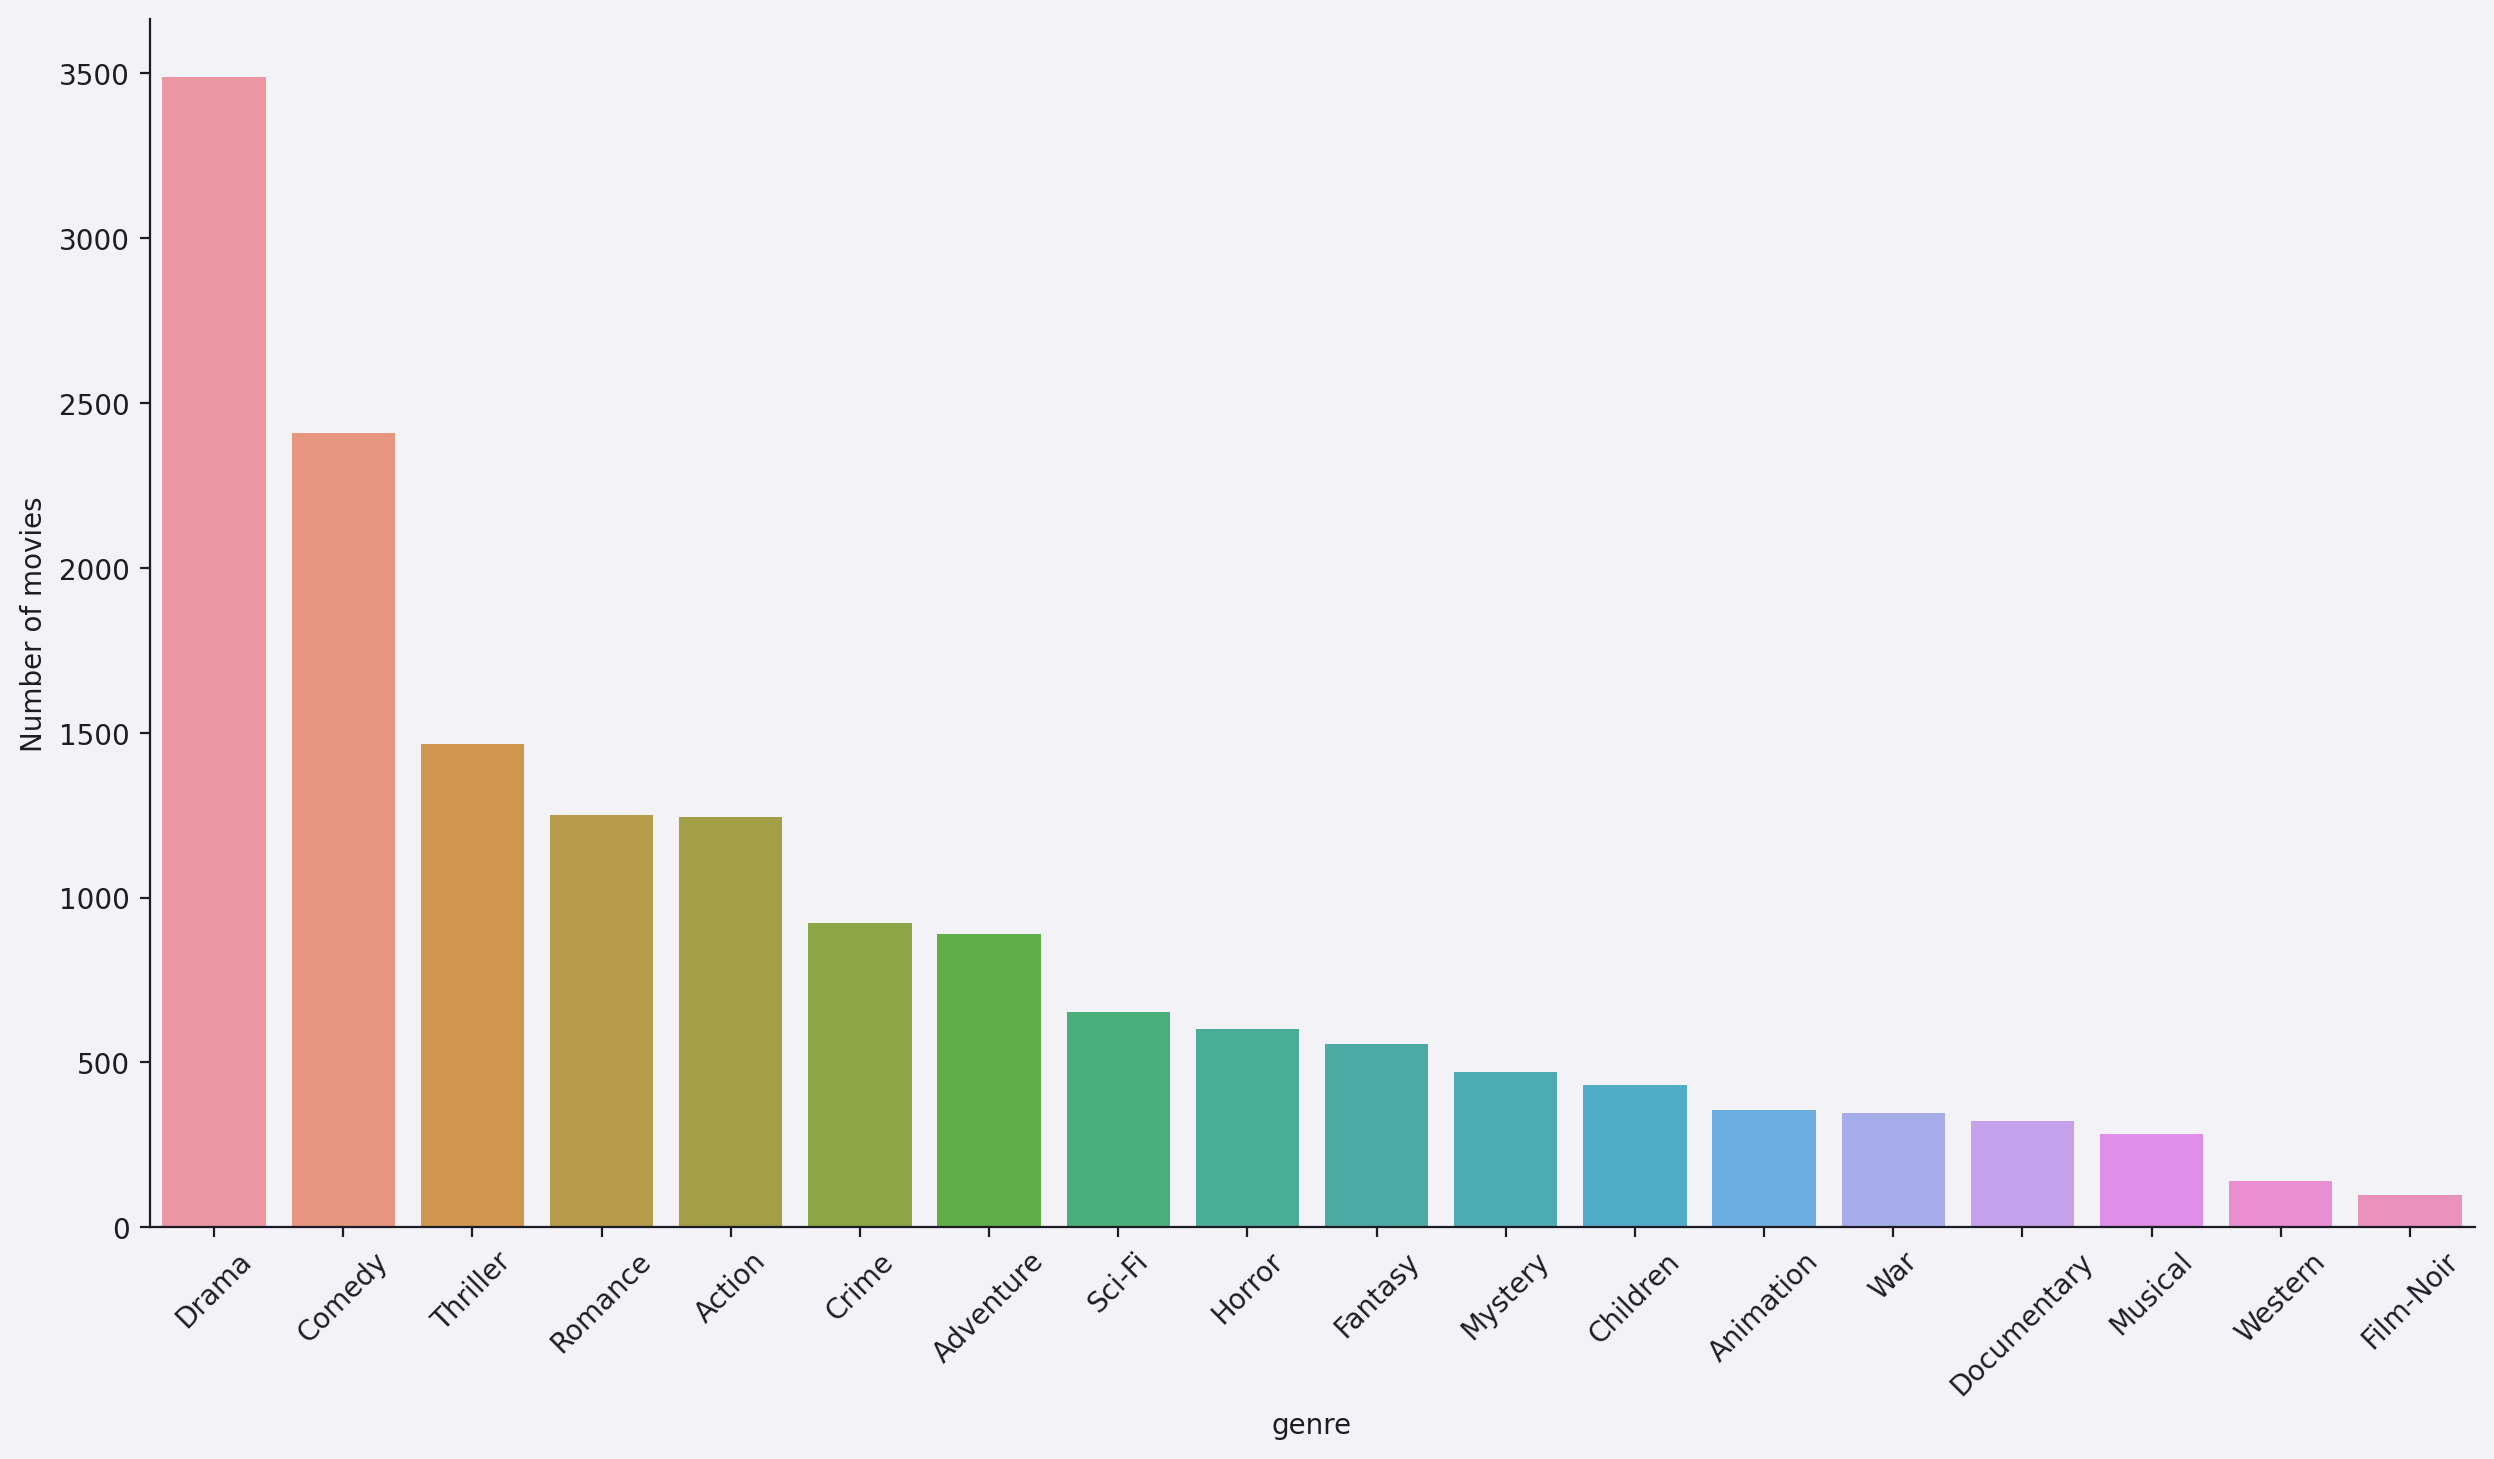

In [56]:
_, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.barplot(x=genre_data_grouped['genre'], y=genre_data_grouped['count'], ax=ax)
plt.ylabel('Number of movies')
plt.xticks(rotation=45)
plt.show()

In [57]:
one_hot_genre = genre_data.set_index('item')['genre'].str.get_dummies().groupby(level=0).sum().reset_index()
one_hot_genre

,item,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,118700,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6803,118900,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6804,118997,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0
6805,119141,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
train_df_merged = pd.merge(train_df_merged, one_hot_genre, how='left', on='item')
train_df_merged

,user,item,time,time_date,time_year,time_month,time_quarter,time_day,time_hour,time_weekday,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,11,4643,1230782529,2009-01-01 04:02:09,2009,1,1,1,4,3,...,0,0,0,0,0,0,1,0,0,0
1,11,170,1230782534,2009-01-01 04:02:14,2009,1,1,1,4,3,...,0,0,0,0,0,0,0,1,0,0
2,11,531,1230782539,2009-01-01 04:02:19,2009,1,1,1,4,3,...,0,0,0,0,0,0,0,0,0,0
3,11,616,1230782542,2009-01-01 04:02:22,2009,1,1,1,4,3,...,0,0,0,0,0,0,0,0,0,0
4,11,2140,1230782563,2009-01-01 04:02:43,2009,1,1,1,4,3,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5154466,138493,44022,1260209449,2009-12-07 18:10:49,2009,12,4,7,18,0,...,0,0,0,0,0,0,0,0,0,0
5154467,138493,4958,1260209482,2009-12-07 18:11:22,2009,12,4,7,18,0,...,0,0,0,0,0,0,0,0,1,0
5154468,138493,68319,1260209720,2009-12-07 18:15:20,2009,12,4,7,18,0,...,0,0,0,0,0,0,1,1,0,0
5154469,138493,40819,1260209726,2009-12-07 18:15:26,2009,12,4,7,18,0,...,0,0,0,1,0,1,0,0,0,0


마지막으로 *directors.tsv* 데이터입니다.
각 column은 다음과 같은 정보를 담고 있습니다.
- *item* : 영화 id
- *director* : 영화 감독(익명화)

In [59]:
director_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5905 entries, 0 to 5904
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   item      5905 non-null   int64 
 1   director  5905 non-null   object
dtypes: int64(1), object(1)
memory usage: 92.4+ KB


In [60]:
director_data.head(10)

,item,director
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005
3,2068,nm0000005
4,7396,nm0000005
5,7820,nm0000005
6,4422,nm0000005
7,7939,nm0000005
8,7938,nm0000005
9,7941,nm0000005


In [61]:
print("Director data shape: ", director_data.shape)
print("Number of unique items in director_data: ", director_data['item'].nunique())
print("Number of unique directors: ", director_data['director'].nunique())

Director data shape:  (5905, 2)
Number of unique items in director_data:  5503
Number of unique directors:  1340


In [62]:
non_director_movies = set(train_df['item'].unique()) - set(director_data['item'].unique())
print("Number of movies that have no information of director: ", len(non_director_movies))

Number of movies that have no information of director:  1304


영화 감독 정보가 없는 영화의 수는 1,304개인데, 이 결측치를 과연 어떻게 채울지가 고민입니다.

In [63]:
director_data_grouped = director_data.groupby(director_data['director'])['item'].count().reset_index(name="director_count")
director_data_grouped['director_count'].describe()

count    1340.000000
mean        4.406716
std         3.633030
min         2.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        44.000000
Name: director_count, dtype: float64

한 영화만 찍은 감독이 없다는 게 신기하네요.
작가에서와 비슷한 양상을 보입니다.

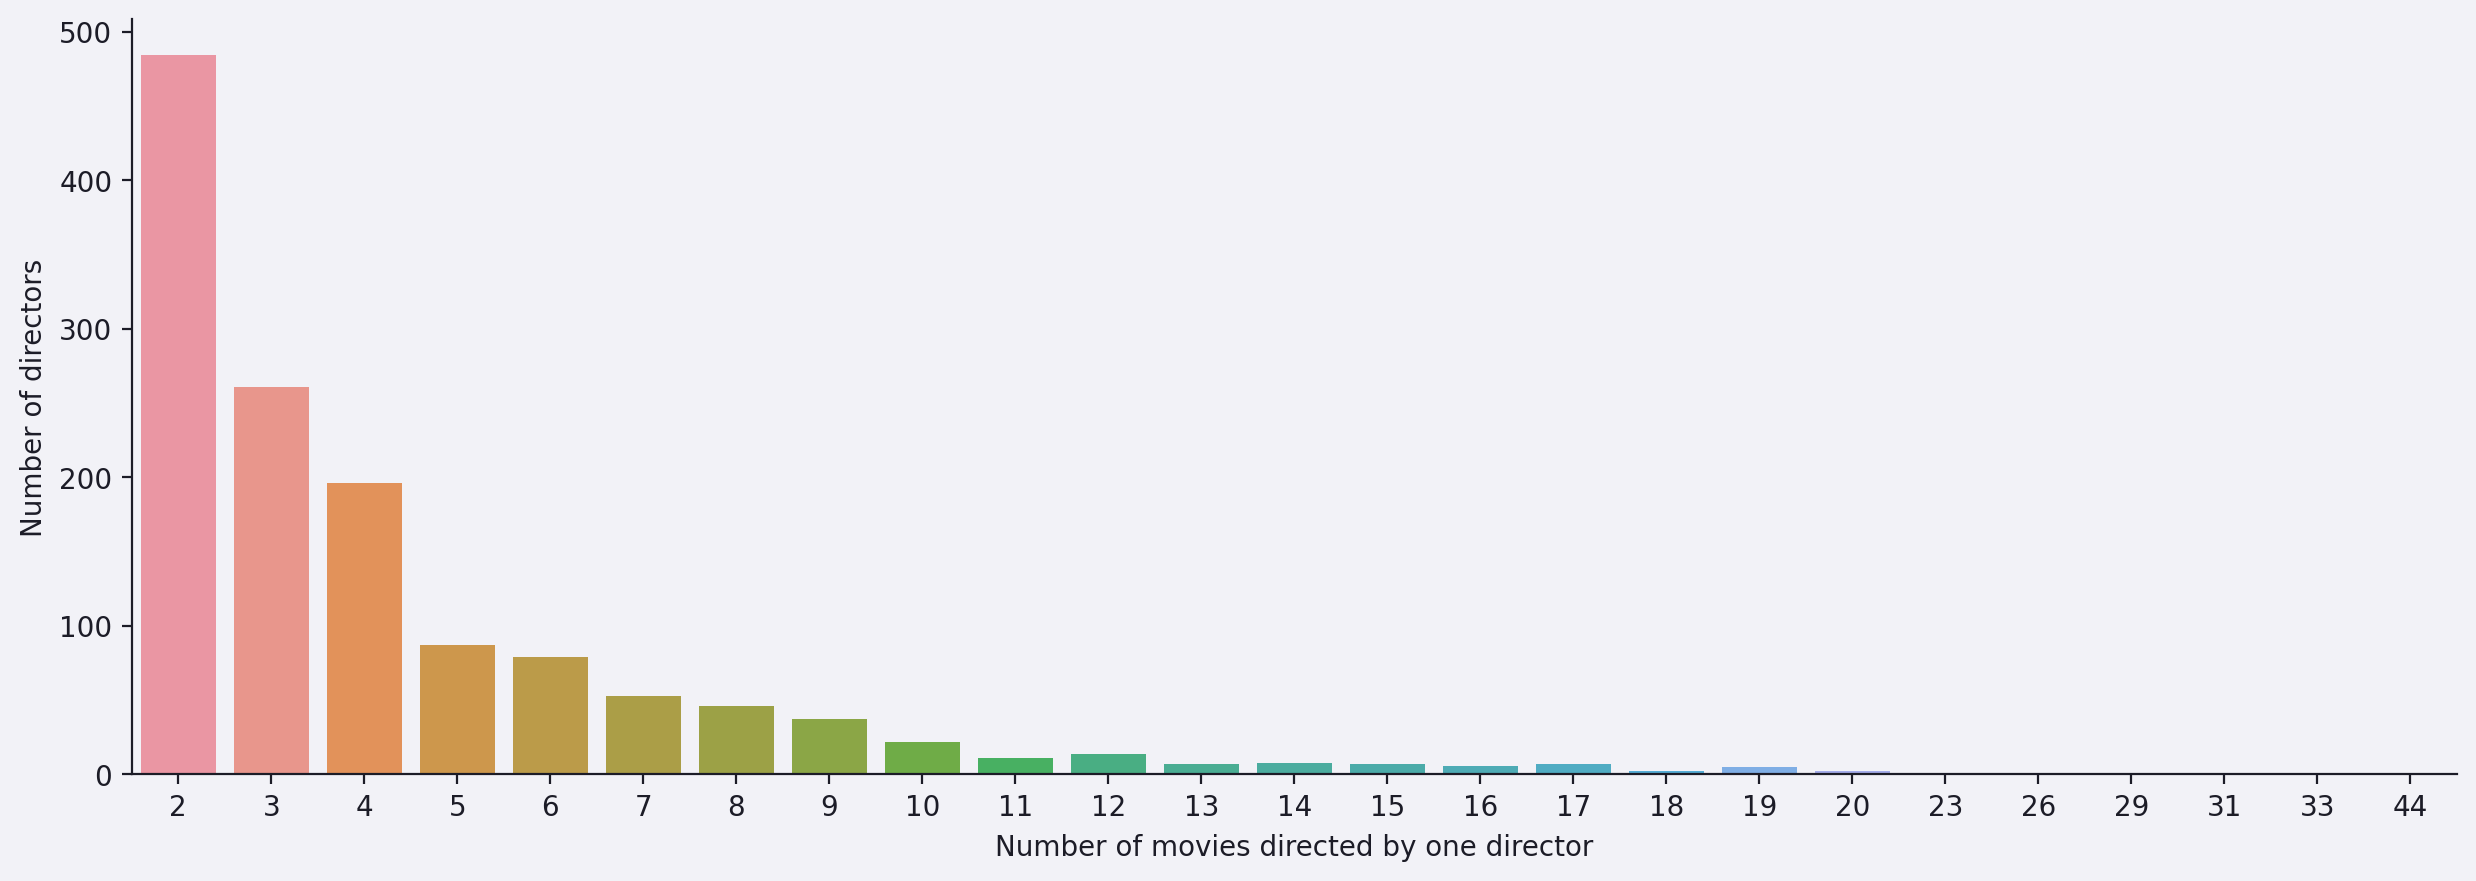

In [64]:
_, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.countplot(x=director_data_grouped['director_count'], ax = ax)
plt.xlabel('Number of movies directed by one director')
plt.ylabel('Number of directors')
plt.show()

## 빈도가 높은 데이터 위주로 분석하기

먼저 효율적인 데이터 시각화를 위해, 데이터셋에서 빈도수가 높은 movie, user 데이터의 id를 미리 저장하겠습니다.
train 데이터에서 데이터의 출현 빈도 순으로 *active_user_ids*와 *popular_movie_ids*에 top 10을 각각 저장합니다.

대회 데이터셋에서 빈도수가 높을수록 유명한 영화를 나타내는 것은 아니지만, 편의상 *popular_movie_id* 변수명을 사용하는 점을 당부드립니다.

다음 코드를 실행해주세요.

In [65]:
active_user_ids = train_df.value_counts('user').index[:10]
popular_movie_ids = train_df.value_counts('item').index[:10]

print ("active user ids: ", active_user_ids)
print ("\npopular movie ids: ", popular_movie_ids)

active user ids:  Int64Index([8405, 54465, 24219, 32514, 91349, 131904, 34576, 99754, 31122,
            118754],
           dtype='int64', name='user')

popular movie ids:  Int64Index([2571, 2959, 296, 318, 356, 4993, 7153, 5952, 593, 2858], dtype='int64', name='item')


*active_user_ids*와 *popular_movie_ids*에 각각 빈도가 높은 영화와 사용자 id들을 저장했습니다.

이제부터는 train 데이터와 side information 데이터를 merge하고, side information 별 user-item 빈도수가 높은 데이터 샘플을 미리 저장합니다.
위에서 저장한 active user id와 popular movie id와 다르게 여기서는 바로 Pandas Dataframe의 형태로 샘플을 저장합니다.
빈도가 가장 높은 10개 side information data가 해당하는 모든 user-item interaction를 저장할 것이므로, 각 side information 데이터 샘플의 크기는 상이합니다.

In [66]:
director_df = pd.merge(train_df, director_data, on=['item'])
director_id = director_df.value_counts('director').index[:10]

side_df = []
for director in director_id:
    side_df.append(director_df.loc[director_df['director'] == director])

director_top = pd.concat(side_df)

print ("Number of all unique director ids: ", director_df['director'].nunique())
print ("\ntop 10 director ids: \n", director_id)
print ("\nsample of top 10 user-director data: \n", director_top.sample(5))
print ("\nshape of the data: ", director_top.shape)

Number of all unique director ids:  1340

top 10 director ids: 
 Index(['nm0000229', 'nm0000233', 'nm0634240', 'nm0000709', 'nm0001392',
       'nm0000217', 'nm0001054', 'nm0000116', 'nm0000399', 'nm0000631'],
      dtype='object', name='director')

sample of top 10 user-director data: 
            user   item        time   director
1558857   60160   4226  1228324753  nm0634240
4177406   25614  64957  1282676488  nm0000399
2446910   90714  72998  1309273799  nm0000116
1150108    9119   1291  1195975556  nm0000229
2448869  134690  72998  1278703369  nm0000116

shape of the data:  (672019, 4)


In [67]:
writer_df = pd.merge(train_df, writer_data, on=['item'])
writer_id = writer_df.value_counts('writer').index[:10]

side_df = []
for writer in writer_id:
    side_df.append(writer_df.loc[writer_df['writer'] == writer])

writer_top = pd.concat(side_df)

print ("Number of all unique writer ids: ", writer_df['writer'].nunique())
print ("\ntop 10 writer ids: \n", writer_id)
print ("\nsample of top 10 user-writer data: \n", writer_top.sample(5))
print ("\nshape of the data: ", writer_top.shape)

Number of all unique writer ids:  2989

top 10 writer ids: 
 Index(['nm0000184', 'nm0000233', 'nm0634240', 'nm0001392', 'nm0909638',
       'nm0004056', 'nm0744429', 'nm0101991', 'nm0254645', 'nm0000175'],
      dtype='object', name='writer')

sample of top 10 user-writer data: 
            user   item        time     writer
2871335   95500   4306  1427033959  nm0254645
2103710  116141    296  1202481114  nm0000233
2927242   26007   5952  1213310756  nm0909638
7063836   17571  79132  1331348676  nm0634240
3725582  130126   7153  1156034532  nm0001392

shape of the data:  (651286, 4)


In [68]:
title_df = pd.merge(train_df, title_data, on=['item'])
title_id = title_df.value_counts('title').index[:10]


side_df = []
for title in title_id:
    side_df.append(title_df.loc[title_df['title'] == title])

title_top = pd.concat(side_df)

print ("Number of all unique movie titles: ", title_df['title'].nunique())
print ("\ntop 10 movie titles: \n", title_id)
print ("\nsample of top 10 user-title data: \n", title_top.sample(5))
print ("\nshape of the data: ", title_top.shape)

Number of all unique movie titles:  6806

top 10 movie titles: 
 Index(['Matrix, The (1999)', 'Fight Club (1999)', 'Pulp Fiction (1994)',
       'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)',
       'Lord of the Rings: The Fellowship of the Ring, The (2001)',
       'Lord of the Rings: The Return of the King, The (2003)',
       'Lord of the Rings: The Two Towers, The (2002)',
       'Silence of the Lambs, The (1991)', 'American Beauty (1999)'],
      dtype='object', name='title')

sample of top 10 user-title data: 
            user  item        time  \
834207    17058   296  1304794180   
861798    92364   356  1265881775   
1072693   20715  5952  1149603671   
234501    84549  2571  1122810154   
817627   125056  2959  1200417592   

                                                 title  
834207                             Pulp Fiction (1994)  
861798                             Forrest Gump (1994)  
1072693  Lord of the Rings: The Two Towers, The (2002)  
234501        

In [69]:
year_df = pd.merge(train_df, year_data, on=['item'])
year_id = year_df.value_counts('year').index[:10]

side_df = []
for year in year_id:
    side_df.append(year_df.loc[year_df['year'] == year])

year_top = pd.concat(side_df)

print ("All unique years: \n", np.sort(year_df['year'].unique())) 
print ("\nNumber of all unique years: ", year_df['year'].nunique())
print ("\ntop 10 years: \n", year_id)
print ("\nsample of top 10 user-year data: \n", year_top.sample(5))
print ("\nshape of the data: ", year_top.shape)

All unique years: 
 [1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935
 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949
 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014]

Number of all unique years:  93

top 10 years: 
 Int64Index([2004, 1999, 2001, 2002, 2006, 2003, 2000, 2005, 1995, 2007], dtype='int64', name='year')

sample of top 10 user-year data: 
            user   item        time  year
2288490   26784  55247  1358306594  2007
1883639   50192     50  1150649469  1995
2429553   16383  53322  1241488085  2007
3378420   20055  34405  1261877358  2005
943956   118706    165  1227318876  1995

shape of the data:  (2173226, 4)


여기까지 director, writer, title, year 데이터를 확인해 보았는데요. 이어서 genre 데이터도 관찰해보겠습니다.
데이터셋에서 genre의 수가 총 18개밖에 없으므로 빈도수가 높은 genre를 따로 저장할 필요 없이, train 데이터와의 merge를 바로 진행하겠습니다.


In [70]:
genre_df = pd.merge(train_df, genre_data, on=['item'])

genre_top = genre_df

print ("All unique genres: \n", np.sort(genre_df['genre'].unique())) 
print ("\nNumber of all unique genres: ", genre_df['genre'].nunique())
print ("\nsample of user-genre data: \n", genre_top.sample(5))
print ("\nshape of the data: ", genre_top.shape)

All unique genres: 
 ['Action' 'Adventure' 'Animation' 'Children' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']

Number of all unique genres:  18

sample of user-genre data: 
             user   item        time    genre
7371474    10527   4246  1157264596   Comedy
4321978    72229   7153  1250901221  Fantasy
11252943  120067  61132  1226106547   Comedy
12078059   84125   4874  1154698584   Sci-Fi
9935442    22309   1304  1138149076  Western

shape of the data:  (14126324, 4)


이제 matplotlib library를 사용하여 샘플한 데이터를 그래프로 시각화해봅니다.

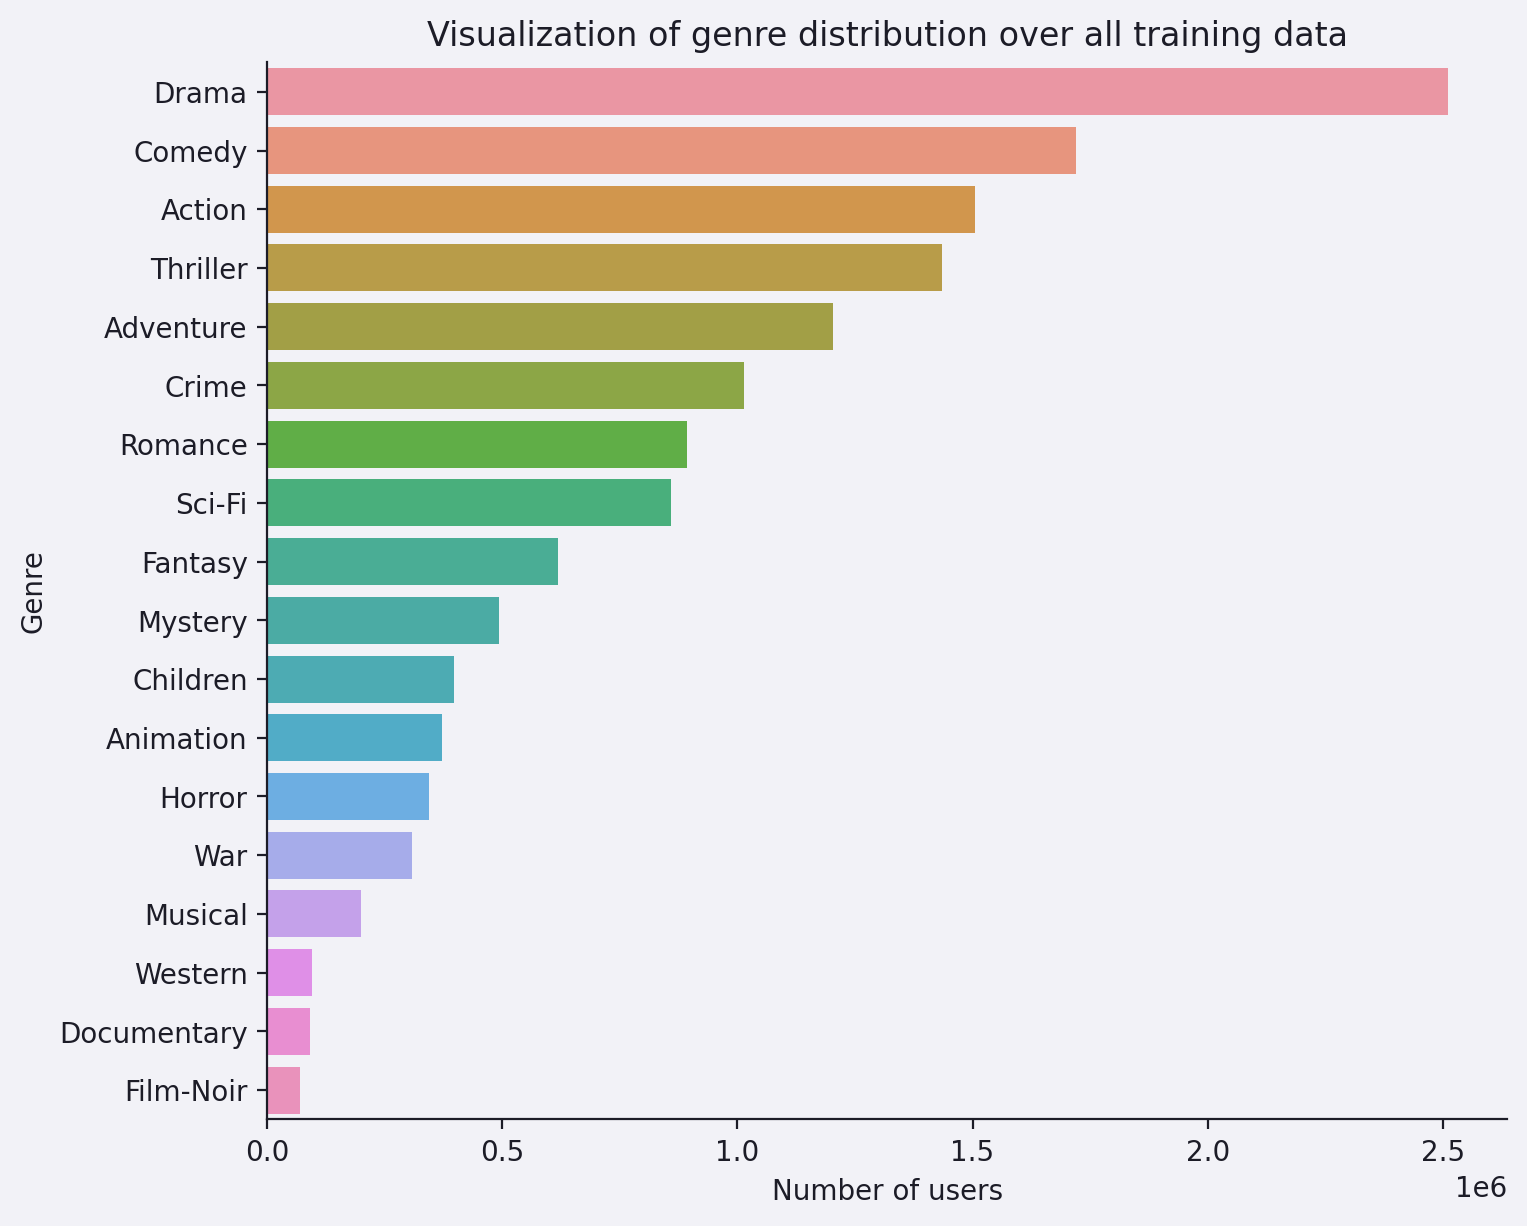

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
sns.countplot(y="genre", data=genre_top, order=genre_top['genre'].value_counts().index, ax=ax)
plt.ylabel('Genre')
plt.xlabel('Number of users')
plt.title('Visualization of genre distribution over all training data')
plt.show()

데이터셋에서 가장 많이 출현하는 장르가 *Drama*, 가장 적게 출현하는 장르가 *Film-Noir*임을 확인할 수 있었습니다.

그러면 전체 training 데이터에서의 genre 분포 뿐만 아니라, genre 데이터 단독의 분포를 출력하면 어떤지 비교해 봅니다.

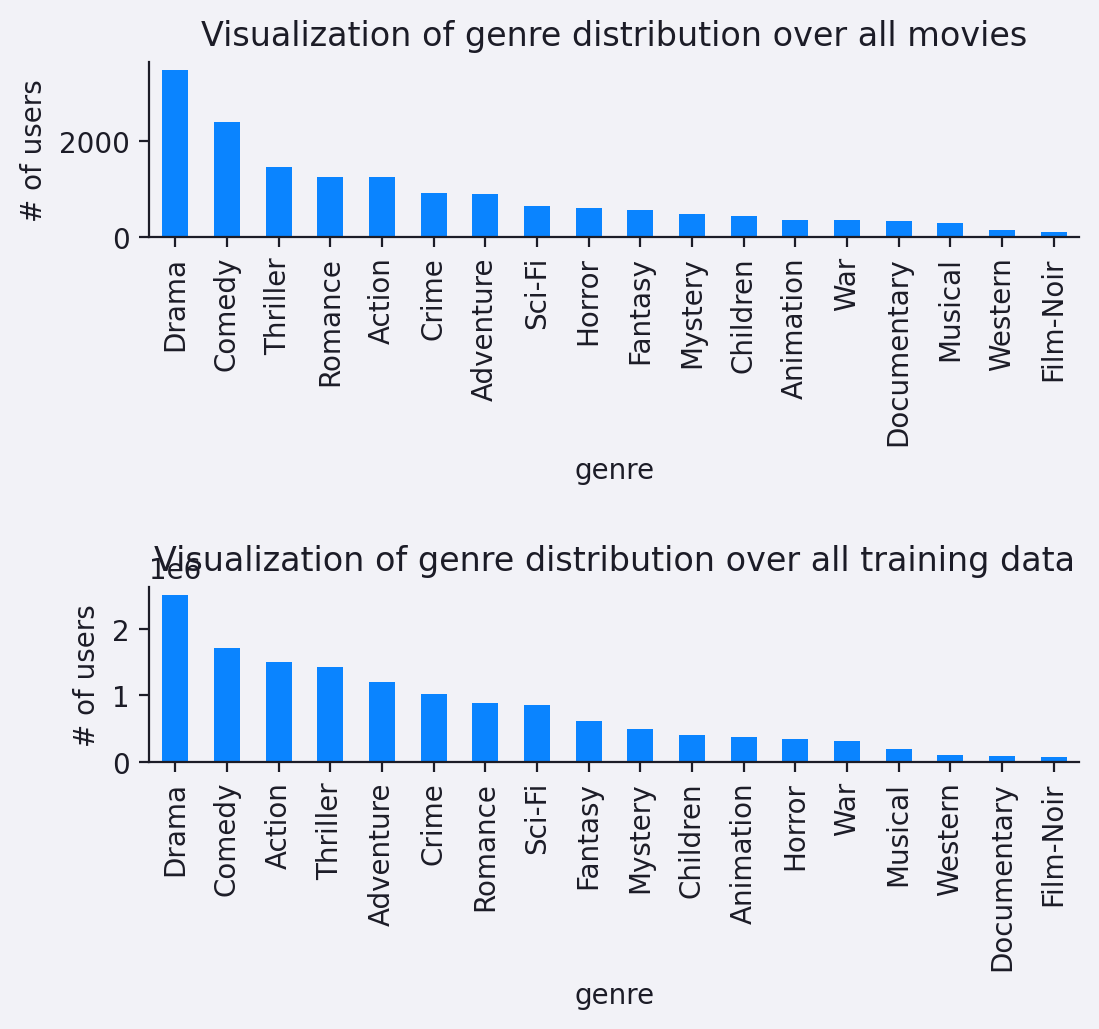

In [72]:
plt.subplot(2,1,1)
genre_data['genre'].value_counts().plot(kind = 'bar')
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all movies')

plt.subplot(2,1,2)
genre_top['genre'].value_counts().plot(kind = 'bar')
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all training data')

plt.subplots_adjust(hspace=2.0, top=1.0)

두 개의 그래프를 확인하면 거의 비슷해보이지만, 두 분포 사이에 작은 차이가 있음을 확인할 수 있습니다.
가령, *Romance* 장르의 영화가 전체 훈련 데이터에서는 7위를 차지하지만, 모든 6807개의 영화 중에서는 4위를 차지합니다.
이는 *Romance* 장르에 해당하는 영화의 갯수에 비해 실제 사용자들이 시청할 확률이 더 높았다는 것을 뜻합니다.

다음은 사용자 한명이 시청한 영화 리스트를 확인하고, 해당 사용자가 가장 선호하는 장르를 순위별로 차트로 알아보겠습니다.
다음 코드에서는 데이터가 가장 많은 사용자의 id인 `active_user_ids[0]`를 사용하겠습니다.

<AxesSubplot:>

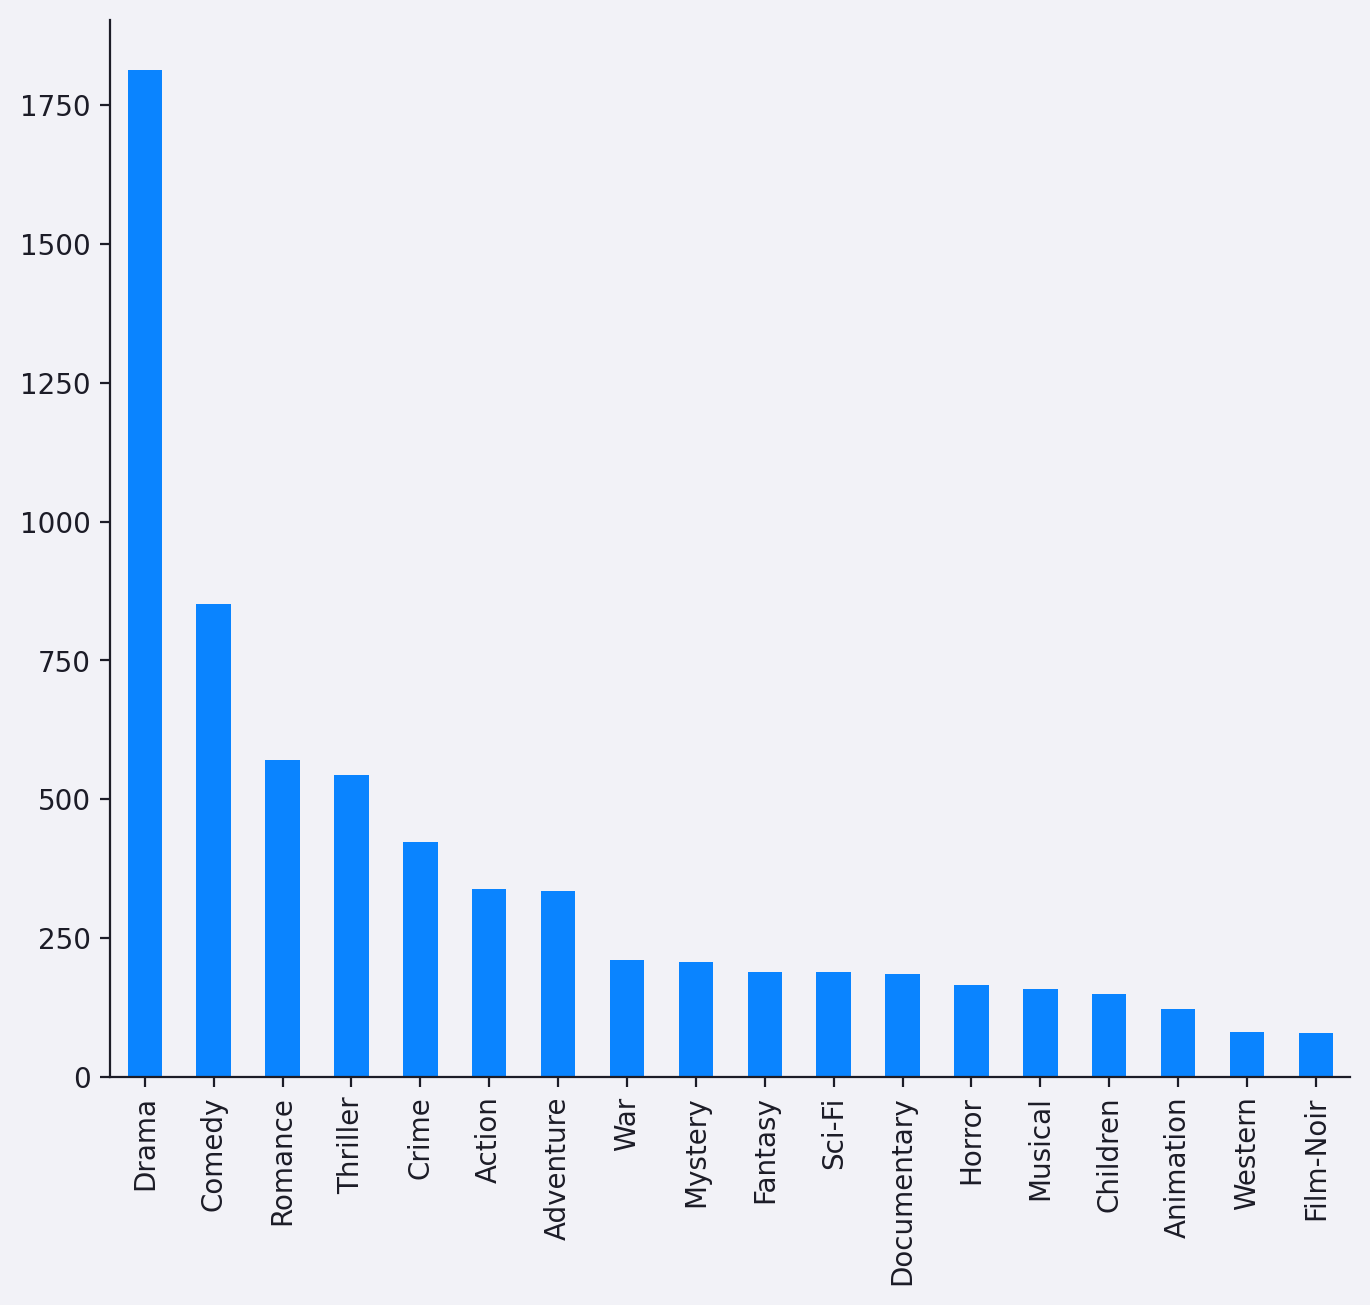

In [73]:
user_id = active_user_ids[0] # specific user id
genre_user = genre_top[genre_top['user'] == user_id]

genre_user['genre'].value_counts().plot(kind = 'bar', figsize = (8,7))

`active_user_ids[0]`에 해당하는 사용자의 시청영화 장르 분포는 전체 데이터의 장르 분포와 크게 차이가 나지 않습니다.
그렇다면 `active_user_ids[1]`에 해당하는 사용자는 어떨까요?


다음은 사용자가 주로 언제 영화를 시청했는지 알아보려고 합니다.

/tmp/ipykernel_9395/2525419202.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  converted_df['time'] = old_df['time'].replace([old_time], new_time) # replace the time column


Text(0.5, 1.0, 'Statistics of user activity')

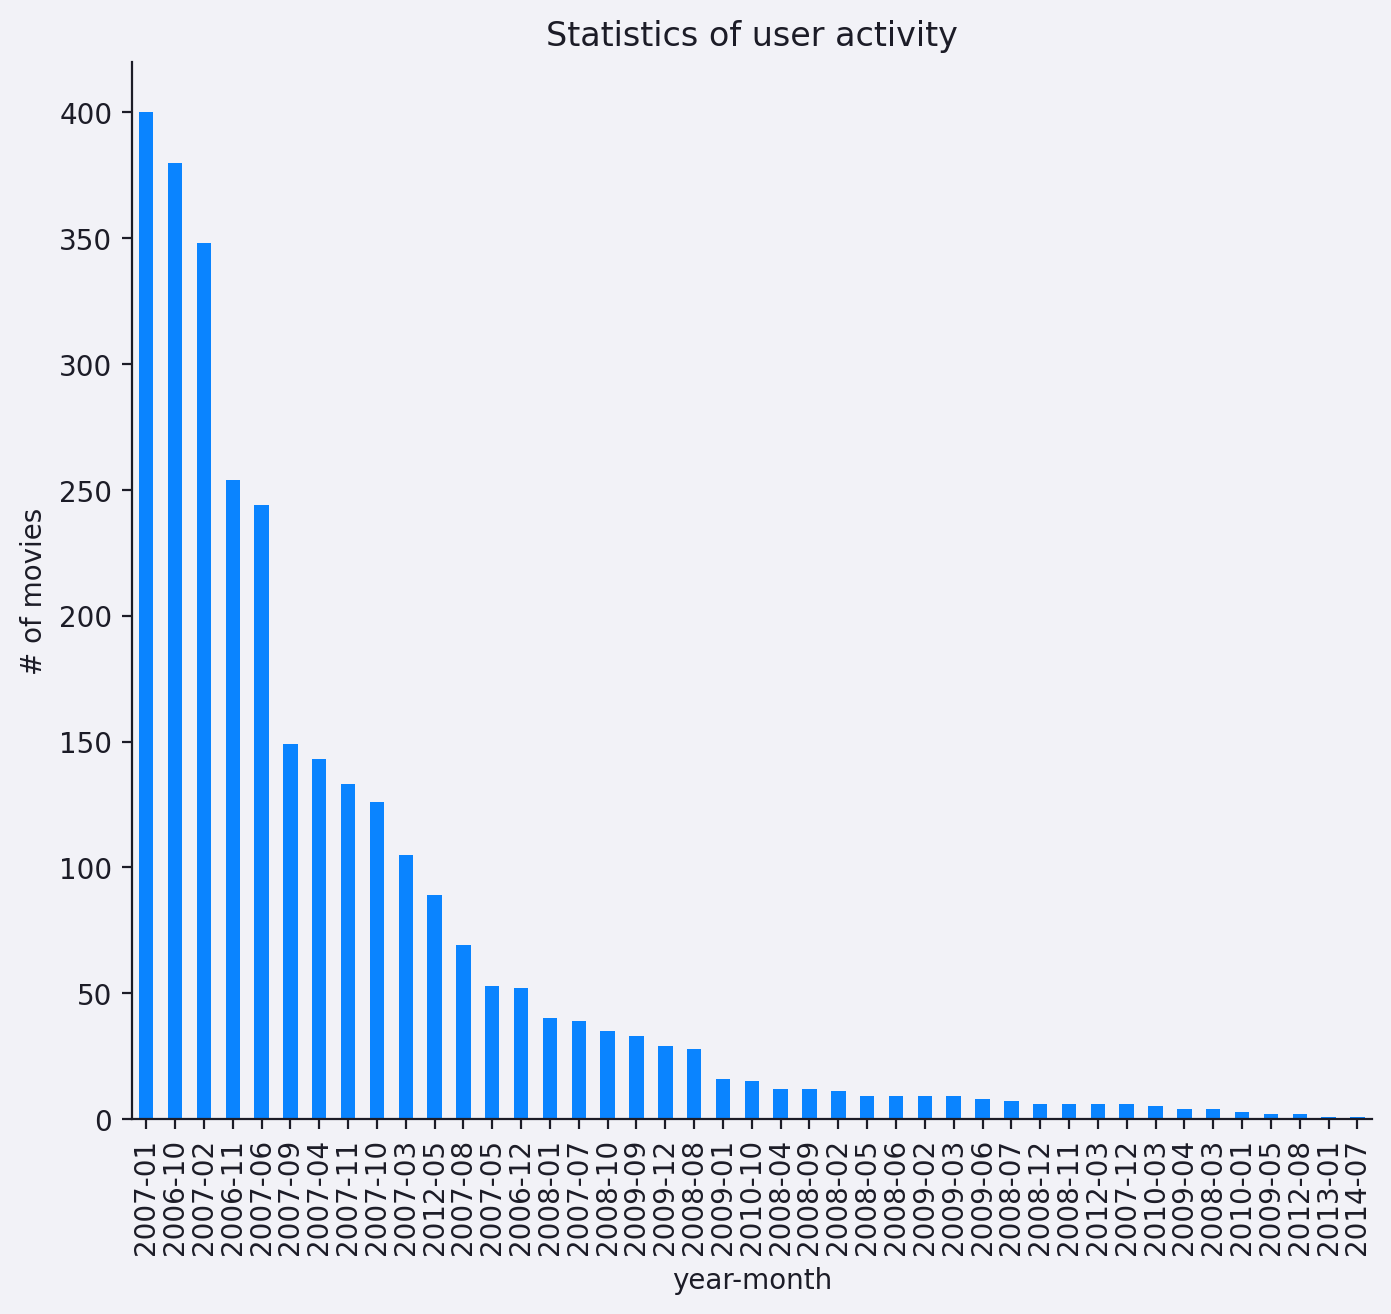

In [74]:
old_df = train_df[train_df['user'] == active_user_ids[0]] # Specific user id
converted_df = old_df

for old_time in old_df['time']:
    new_time = time.strftime('%Y-%m', time.localtime(old_time))
    converted_df['time'] = old_df['time'].replace([old_time], new_time) # replace the time column

converted_df['time'].value_counts().plot(kind = 'bar', figsize = (8,7))
plt.xlabel('year-month')
plt.ylabel('# of movies')
plt.title('Statistics of user activity')

해당 사용자는 대략 2007년 전후로 영화 시청을 가장 많이 했고, 시간이 지나면서 시청 기록이 점점 줄어드는 확인할 수 있습니다.

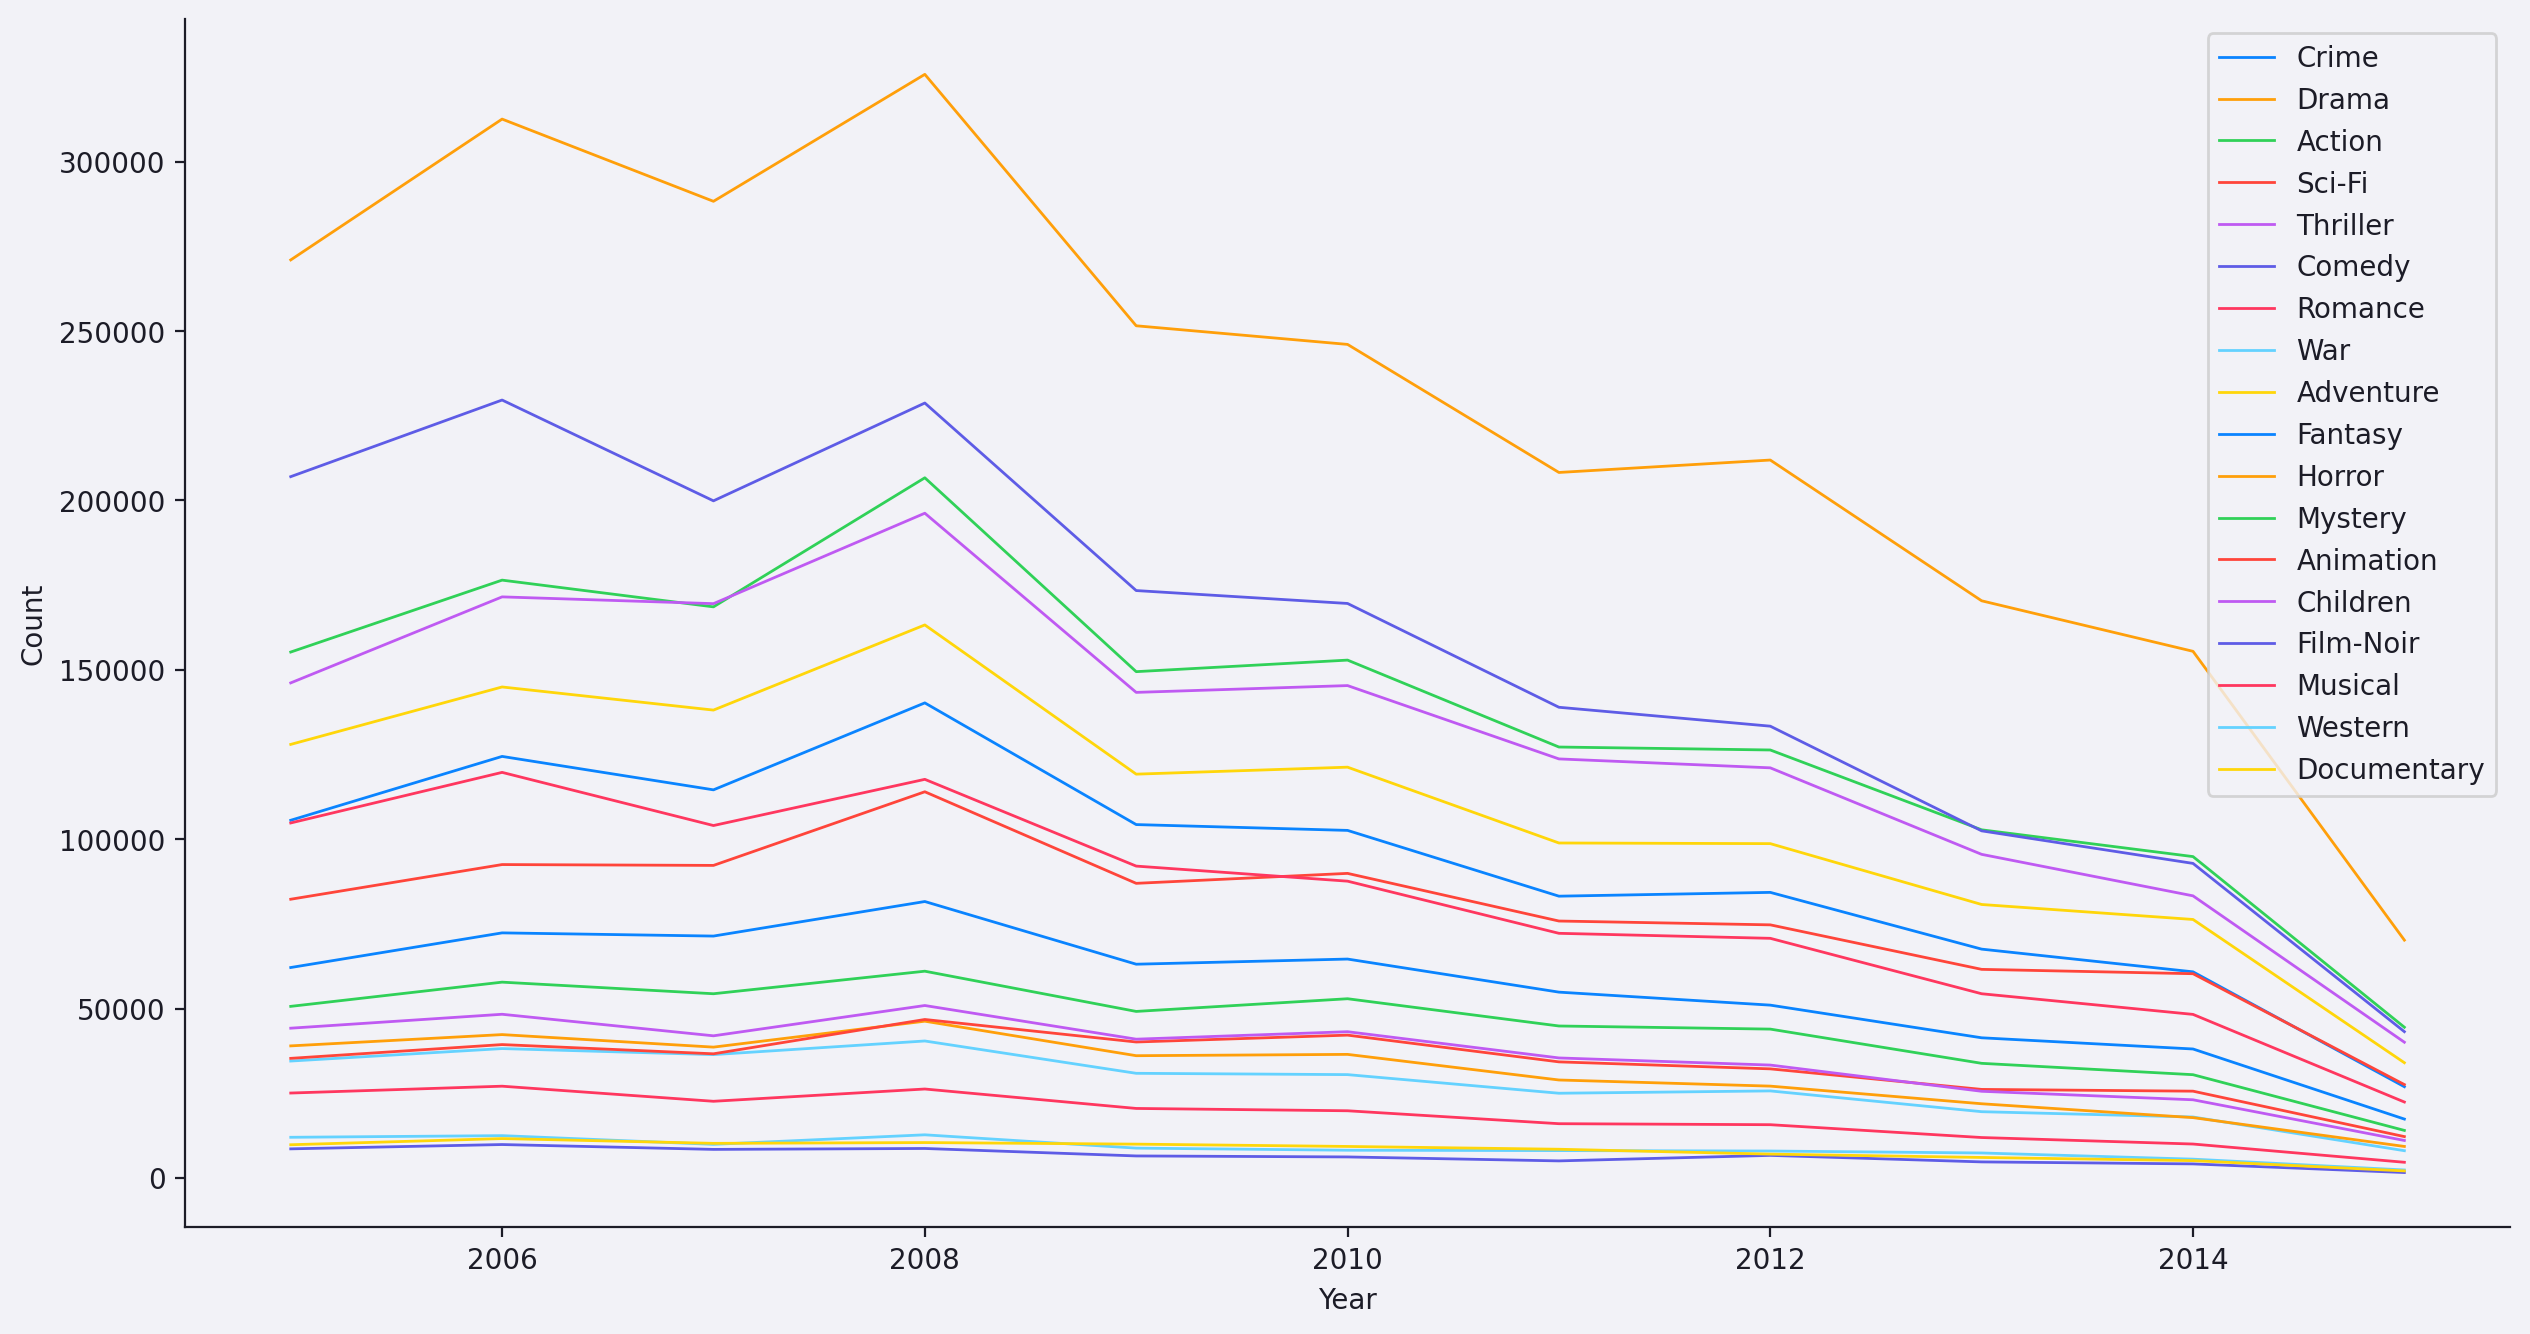

In [75]:
_, ax = plt.subplots(1, 1, figsize=(15,8))
train_df_merged_year = train_df_merged[['time_year'] + list(genre_data['genre'].unique())].groupby('time_year').sum().reset_index()
for num,column in enumerate(list(genre_data.set_index('item')['genre'].unique())):
    ax.plot(train_df_merged_year['time_year'], train_df_merged_year[column], linewidth=1, label=column)

plt.legend(loc='upper right')
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

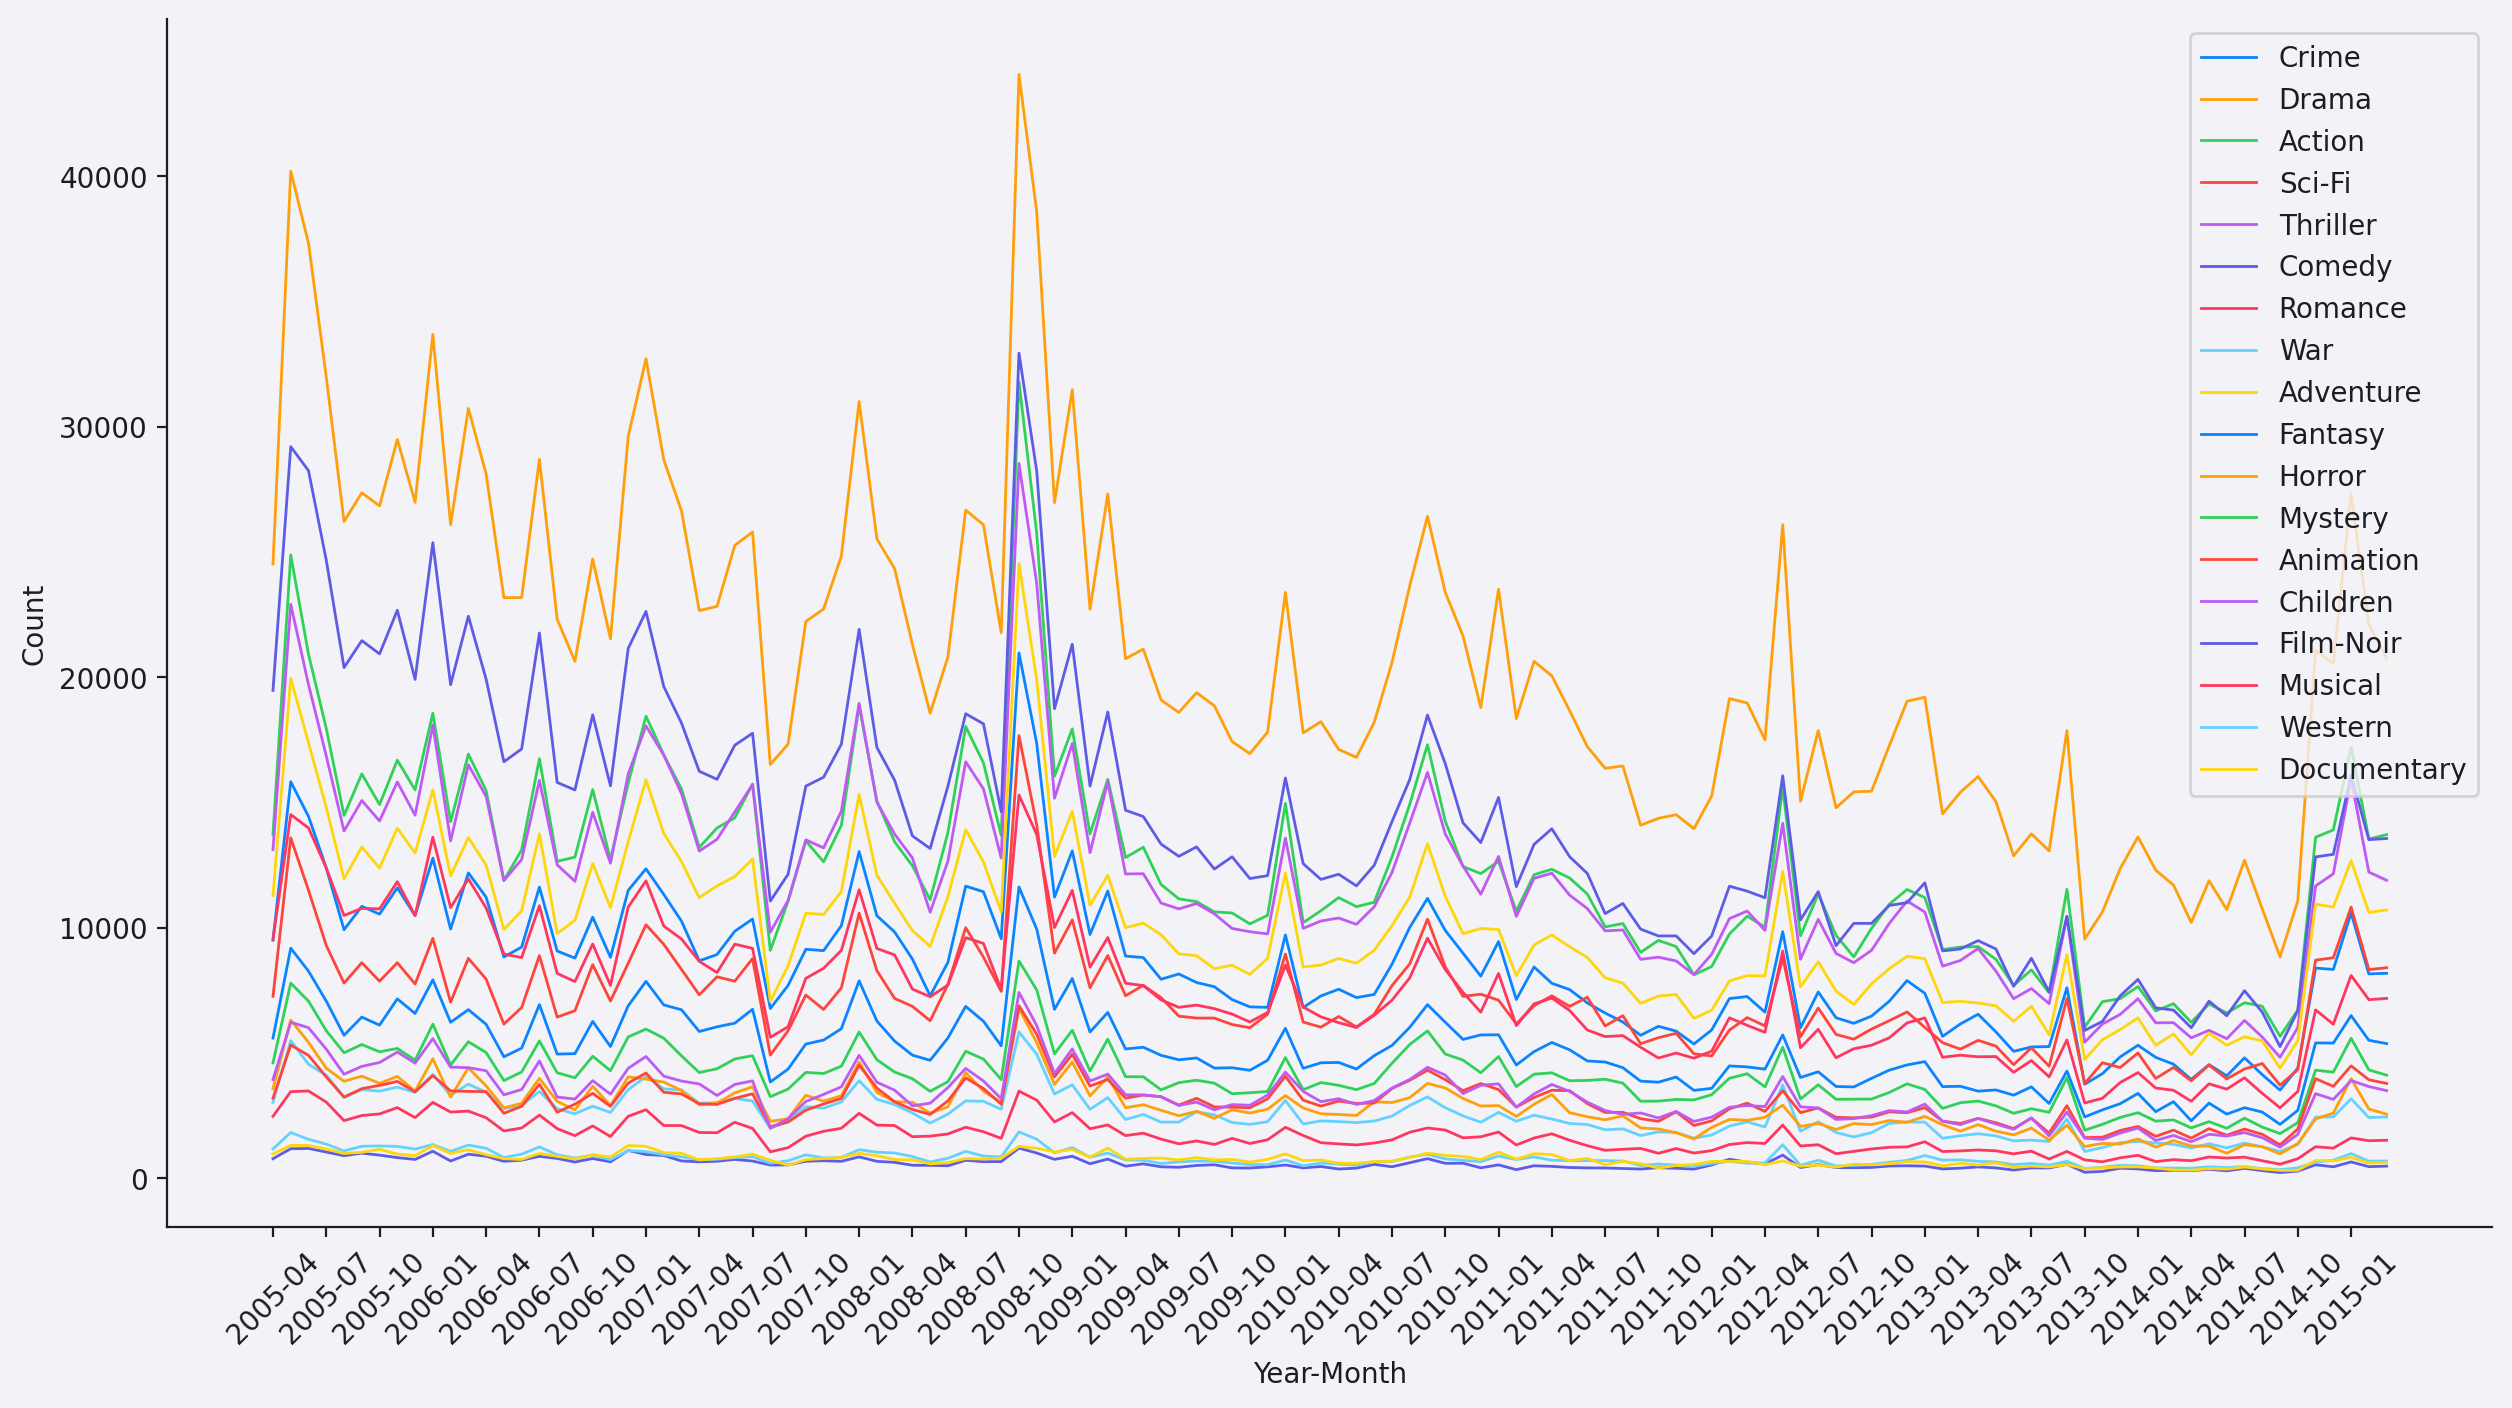

In [76]:
_, ax = plt.subplots(1, 1, figsize=(15,8))
train_df_merged_year_month = train_df_merged.set_index(['time_year', 'time_month'])[list(genre_data['genre'].unique())].groupby(level=[0,1]).sum().reset_index()
train_df_merged_year_month['time_month'] = train_df_merged_year_month['time_month'].astype('str').str.zfill(2)
train_df_merged_year_month['time_year_month'] = train_df_merged_year_month['time_year'].astype('str') + '-' + train_df_merged_year_month['time_month'].astype('str')
train_df_merged_year_month = train_df_merged_year_month.drop(['time_year', 'time_month'], axis=1)
for num,column in enumerate(list(genre_data.set_index('item')['genre'].unique())):
    ax.plot(train_df_merged_year_month['time_year_month'], train_df_merged_year_month[column], linewidth=1, label=column)

plt.legend(loc='upper right')
plt.xticks(rotation=45)
ax.set_xticks(ax.get_xticks()[::3])
plt.xlabel("Year-Month")
plt.ylabel("Count")
plt.show()